##### This notebook is the continuation of the YouNiverse_exploration notebook where you can find the basic video exploration analysis over the years.
This notebook focuses on the other techniques uses to dive deeper into analysis of the content on YouTube which is the following:

- CDF analysis
- Sentiment analysis
    - Labeling
    - Words selection
    - Exact Matching
- Graph Creation:
    - Data processing
    - Creation of the graph
    - Graph pruning
    - Graph analysis
    - Graph plotting 
    - Circle graph of connected categories of the videos
    - Comparison

### Imports

In [1]:
import warnings; warnings.simplefilter('ignore')
from sklearn.feature_extraction.text import CountVectorizer
import unicodedata as ud

from scipy import stats
import spacy
import en_core_web_sm

import itertools
import networkx as nx
import simplejson as json
from networkx.readwrite import json_graph
import community as community_louvain

import seaborn as sns 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as SIA # conda install -c conda-forge vadersentiment
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer

### Preparation of the data

In [2]:
dfs = []
for df_json in pd.read_json('yt_metadata_en.jsonl.gz', compression="infer", chunksize=5000000, lines=True):
    df_json.drop(["description", "dislike_count", "crawl_date"], inplace=True, axis=1)
    df_json["upload_date"] = pd.to_datetime(df_json["upload_date"])
    dfs.append(df_json)

In [3]:
df = pd.concat(dfs)

In [4]:
df['upload_date'] = pd.to_datetime(df['upload_date'])
df = df.dropna(axis=0)
df["upload_year"] = df['upload_date'].apply(lambda d: d.year)

In [6]:
df.reset_index().to_feather(f'yt_metadata_wo_desc_dislike.feather')

### Importing Data


In [2]:
df = pd.read_feather('yt_metadata_wo_desc_dislike.feather')

# 1 CDF analysis

Deriving from the fact that in 2011 around 30% of videos on YouTube were responsible for 99% of views on the platform, we would like to explore that fact and look at how this percentage changed over the years.

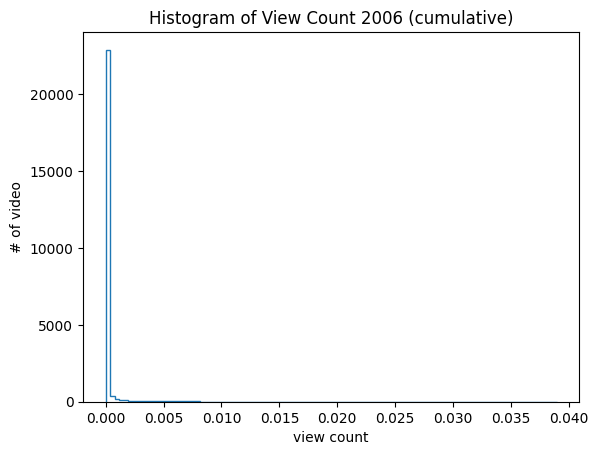

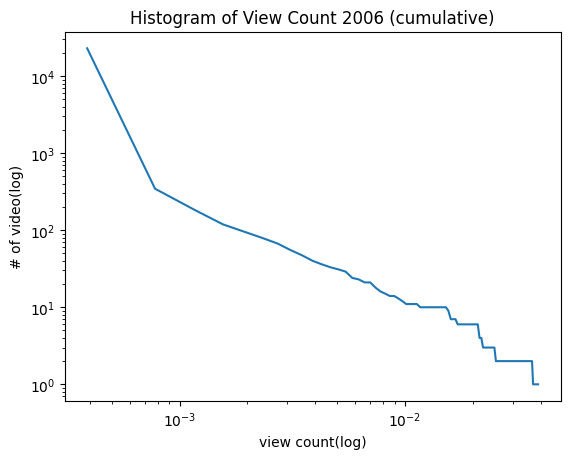

In [3]:
def plot_CDF(df, year):
    df_ = df[df.upload_year == year]
    array_cumulative=plt.hist(df_.view_count/(df_.view_count.sum()), bins=100, cumulative=-1,histtype='step')
    plt.title(f'Histogram of View Count {year} (cumulative)')
    plt.ylabel('# of video')
    plt.xlabel('view count')
    plt.show();
    
    plt.loglog(array_cumulative[1][1:], array_cumulative[0])
    plt.title(f'Histogram of View Count {year} (cumulative)')
    plt.ylabel('# of video(log)')
    plt.xlabel('view count(log)')
    plt.show();
    
plot_CDF(df, 2006)

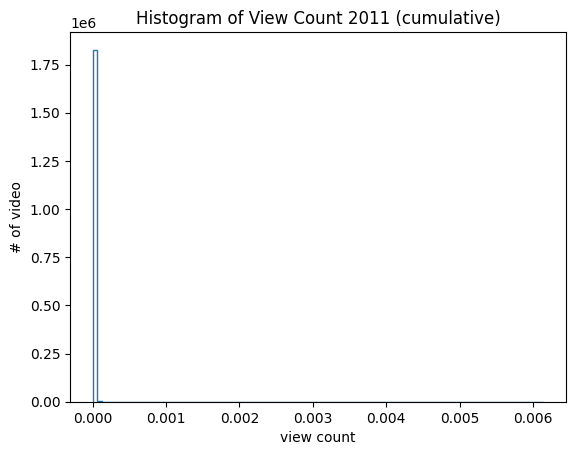

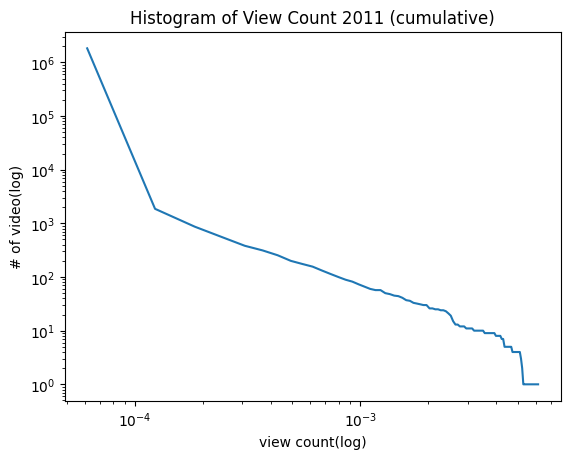

In [4]:
plot_CDF(df, 2011)

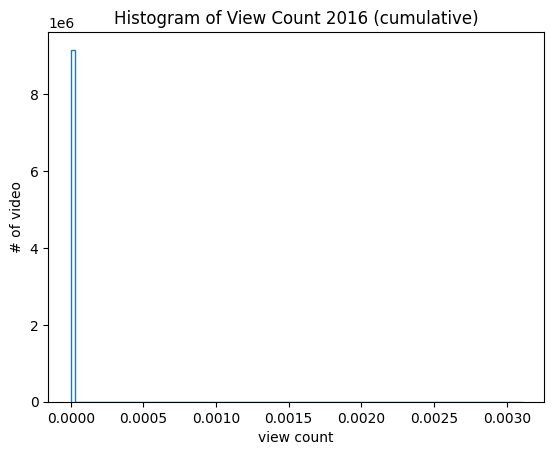

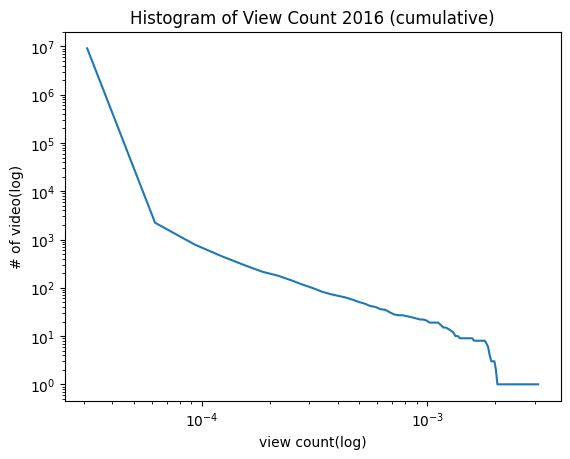

In [5]:
plot_CDF(df, 2016)

We can see that over years we have chosen the CDF in the log scale is almost the same. And it doesn't confirm the uniqueness of fact that we have. Let's look at the timeline to get a more general view of the video views. 

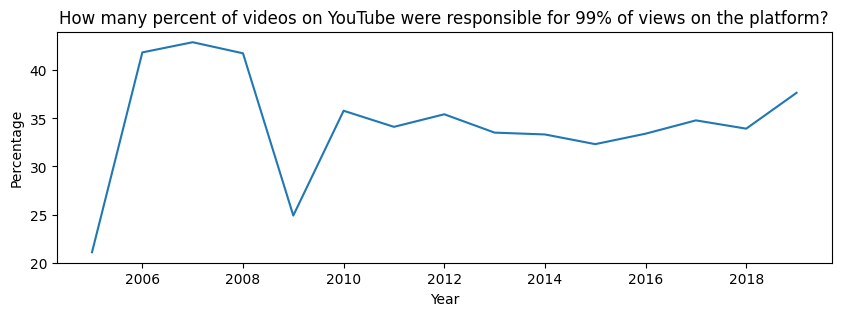

In [6]:
years = np.unique(df.upload_year)

distr = []
for y in years:
    df_y = df[df.upload_year == y]
    percentages = (df_y.view_count/(df_y.view_count.sum())).sort_values(ascending=False).values
    threashold = 0.99
    num_vid = 0
    sum_views = 0
    for i in percentages:
        if sum_views >= threashold:
            break
        sum_views += i
        num_vid += 1
    distr.append(num_vid/len(df_y) * 100)
fig, axs = plt.subplots(1, 1, figsize=(10,3))
sns.lineplot(x=years, y=distr)
axs.set_xlabel("Year");
axs.set_ylabel("Percentage")
axs.set_title("How many percent of videos on YouTube were responsible for 99% of views on the platform?");

Here we can see that give or take the 35% of the videos are responsible for 99% of the views in a platform from 2010 to 2018(stable period).\
Frankly, it was expected to see a higher percentage at the beginning of YouTube, but strange to see it in 2009(maybe because of the changes in YouTube policy). 

In addition, we want to explore the contribution of videos with different duration to the total amount of views on YouTube.

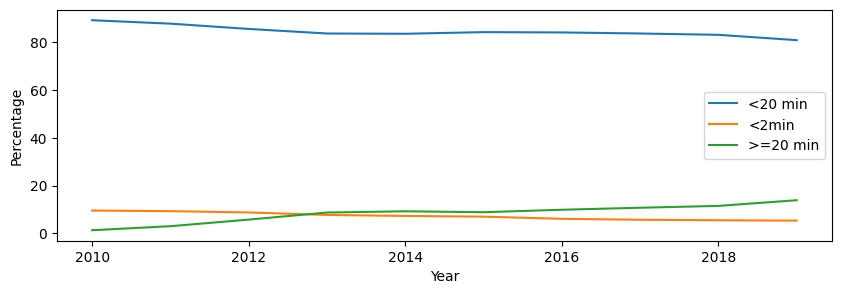

In [5]:
# duration 
def duration_split(val):
    if (2*60 <= val < 20*60): return '<20 min'
    elif val >= 20*60: return '>=20 min'
    elif val < 2*60: return '<2min'
    
df['duration_categ'] = df.duration.apply(duration_split)
duration_categories = np.unique(df.duration_categ)

fig, axs = plt.subplots(1, 1, figsize=(10,3))
distr = []
for d in duration_categories:
    for y in range(2010, 2020, 1):
        df_d = df[(df.upload_year == y) & (df.duration_categ == d)]
        df_y = df[(df.upload_year == y)]
        percentages = (df_d.like_count.sum()/(df_y.like_count.sum()))
        distr.append(percentages * 100)
    sns.lineplot(x=range(2010, 2020, 1), y=distr, label=d)
    distr = []
    axs.legend()
    
axs.set_xlabel("Year")
axs.set_ylabel("Percentage")
axs.set_title("")
plt.show()

The videos that have a duration of less than 20 min prevail over the other videos, but there is a tendency for the longer videos to dominate the really small ones starting from 2013.

### Using a parallel library to speedup the processing of the dataset

In [88]:
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 48 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# 2. Sentiment Analysis

The aim of this method is to analyse the positive and negative content on YouTube within the title of the video.

### 2.1 Labeling

In [8]:
# Here we used SentimentIntensityAnalyzer to detect polarity (e.g. negative , positive or neutral content) within title of the video / categorize title of the videos.
sia = SIA()

def polarity_score(row):
    res = sia.polarity_scores(row.title)
    row['neg'] = res['neg']
    row['neu'] = res['neu']
    row['pos'] = res['pos']
    row['compound'] = res['compound']
    return row

In [9]:
df_merged = df.parallel_apply(polarity_score, axis = 1)
df_merged.sample(20)

In [8]:
# max and min value of compound over the years: 
records_by_year = df_merged.groupby(by=['upload_year'])['compound'].agg(['max','min', 'mean'])
records_by_year

,max,min,mean
upload_year,,,
2005,0.6369,-0.8807,-0.000845
2006,0.9950,-0.9169,0.011251
2007,0.9854,-0.9451,0.022846
2008,0.9854,-0.9649,0.032331
2009,0.9863,-0.9642,0.033127
2010,0.9987,-0.9710,0.037308
2011,0.9930,-0.9806,0.031707
2012,0.9888,-0.9890,0.036139
2013,0.9928,-0.9880,0.036265


In [11]:
# 'compound' scores the sentiment.
# We will consider videos with a compound value greater than 0.5 as positive and less than -0.5 as negative.
df_merged['label'] = 0
df_merged.loc[df_merged['compound'] > 0.5, 'label'] = 1
df_merged.loc[df_merged['compound'] < -0.5, 'label'] = -1
df_merged.head(2)

,index,categories,channel_id,display_id,duration,like_count,tags,title,upload_date,view_count,upload_year,neg,neu,pos,compound,label
0,0,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,SBqSc91Hn9g,1159,8.0,"lego city,lego police,lego city police,lego ci...",Lego City Police Lego Firetruck Cartoons about...,2016-09-28,1057.0,2016,0.0,1.000,0.000,0.000,0
1,1,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,UuugEl86ESY,2681,23.0,"Lego superheroes,lego hulk,hulk smash,lego mar...",Lego Marvel SuperHeroes Lego Hulk Smash Iron-M...,2016-09-28,12894.0,2016,0.0,0.474,0.526,0.875,1


In [12]:
df_merged.to_feather('yt_metadata_wo_desc_dislike_with_sentiments.feather')

In [7]:
df_merged = pd.read_feather('yt_metadata_wo_desc_dislike_with_sentiments.feather')

In [7]:
df_merged[(df_merged.compound == max(df_merged.compound))] 

,index,categories,channel_id,display_id,duration,like_count,tags,title,upload_date,view_count,upload_year,neg,neu,pos,compound,label
29219012,29812675,Entertainment,UCVEIdDDGRe2mQh1fd5qCP5A,BrA5_StY-6E,1023,2872.0,"Critical Ops Aim,critical ops tips,critical op...",Critical Ops Ranked - MET MY BEST FRIEND MATT💗...,2018-03-12,95216.0,2018,0.013,0.034,0.953,0.9994,1


In [8]:
df_merged[(df_merged.compound == min(df_merged.compound))] 

,index,categories,channel_id,display_id,duration,like_count,tags,title,upload_date,view_count,upload_year,neg,neu,pos,compound,label
63831191,65269987,Entertainment,UC3EUHLwqk0vTtqi4Jcb4GLw,31R1oD5IUNY,136,371.0,,FACE REVEAL!!!!!!!!!!!!!😱😱😱😱😱😱😱😱😱😱😱😱😱😱😱😱😱😉😱😱😱😱...,2019-04-01,2948.0,2019,0.733,0.267,0.0,-0.9995,-1


In [13]:
print(df_merged.label.value_counts())
# percentage
print(df_merged.label.value_counts(normalize=True) * 100)

 0    57833203
 1     8243405
-1     5216728
Name: label, dtype: int64
 0    81.120069
 1    11.562659
-1     7.317273
Name: label, dtype: float64


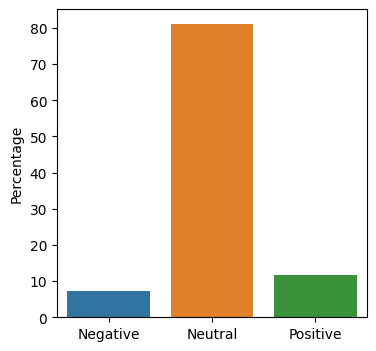

In [14]:
# ploting percentage of negative, neutral and positive content over years
fig, ax = plt.subplots(figsize=(4,4))

counts = df_merged.label.value_counts(normalize=True) * 100

sns.barplot(x=counts.index, y=counts, ax=ax)

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")

plt.show();

The large number of neutral titles is due to two main reasons:

1. The assumption that we made earlier where titles with 'compound' value between 0.5 and -0.5 are considered neutral. The higher the margin, the larger the number of neutral headlines.
2. The titles of the video usually meant to be neutral.

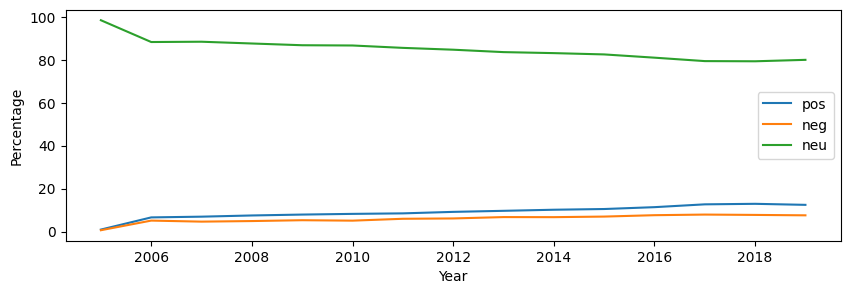

In [15]:
# Timeline of negative, neutral and positive content
t = pd.DataFrame(columns=['year'])
years = list(np.unique(df.upload_year))

for y in years:
    ind = df_merged[(df_merged.upload_year == y)].label.value_counts(normalize = True).sort_index().index
    row = df_merged[(df_merged.upload_year == y)].label.value_counts(normalize = True).sort_index().values * 100
    if len(ind) == 1:
        df_count = pd.DataFrame({'year': y, str(ind[0]): row[0]}, index=[0])
        t = pd.concat((df_count, t), ignore_index = True) 
    if len(ind) == 2:
        df_count = pd.DataFrame({'year': y, str(ind[0]): row[0], str(ind[1]): row[1]}, index=[0])
        t = pd.concat((df_count, t), ignore_index = True) 
    if len(ind) == 3:
        df_count = pd.DataFrame({'year': y, str(ind[0]): row[0], str(ind[1]): row[1], str(ind[2]): row[2]}, index=[0])
        t = pd.concat((df_count, t), ignore_index = True) 
t = t.fillna(0)
fig, axs = plt.subplots(1, 1, figsize=(10,3))
sns.lineplot(x="year", y="1", data=t, label="pos")
sns.lineplot(x="year", y="-1", data=t, label="neg")
sns.lineplot(x="year", y="0", data=t, label="neu")
axs.set_xlabel("Year")
axs.set_ylabel("Percentage");

The positive content prevails over the negative content over the years.

### 2.2 Words selection

In [85]:
# Let's choose the specific year and see what words can influence the score above.
# We can grab all of the positive label / negative label videos from our dataframe, then call NLTK's `FreqDist` function to get the most common words in the positive / negative titles :
# Load the English language model
nlp = en_core_web_sm.load()


#TODO: Update it to use only lowercase instead
def word_sentiment_freq(YEAR, df, num):
    pos_lines = df[(df.label == 1) & (df.upload_year == YEAR)].title
    neg_lines = df[(df.label == -1) & (df.upload_year == YEAR)].title
    
    # Tokenize the strings and remove stop words in parallel using pandarallel
    pos_tokens = pos_lines.parallel_map(lambda line: [token.text for token in nlp(line.lower()) if (not token.is_stop) and token.lang_ == 'en' and token.is_alpha])
    neg_tokens = neg_lines.parallel_map(lambda line: [token.text for token in nlp(line.lower()) if (not token.is_stop) and token.lang_ == 'en' and token.is_alpha])
    
    # Flatten the list of token lists into a single list
    pos_tokens = [token for sublist in pos_tokens for token in sublist]
    neg_tokens = [token for sublist in neg_tokens for token in sublist]
    
    pos_freq = nltk.FreqDist(pos_tokens)
    neg_freq = nltk.FreqDist(neg_tokens)
    
    pos_freq = pos_freq.most_common(num)
    neg_freq = neg_freq.most_common(num)
    return pos_freq, neg_freq

In [86]:
def plot_words(year, pos, neg, x_lim):
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    ax_sns_pos = sns.barplot(x=[pos[i][1]for i in range(len(pos))], y=[pos[i][0] for i in range(len(pos))], color='blue', ax=ax[0])
    ax_sns_neg = sns.barplot(x=[neg[i][1]for i in range(len(neg))], y=[neg[i][0] for i in range(len(neg))], color='blue', ax=ax[1])
    ax_sns_pos.set(xlabel="Count of pos words", ylabel=None)
    ax_sns_neg.set(xlabel="Count of neg words", ylabel=None)
    fig.tight_layout()
    ax_sns_neg.set_xlim(0,x_lim)
    ax_sns_pos.set_xlim(0,x_lim)
    fig.suptitle(f"Positive words {year}", fontsize=25)
    fig.subplots_adjust(top=0.90)
    plt.show();

In [89]:
YEAR = 2019
pos_freq_2019, neg_freq_2019 = word_sentiment_freq(YEAR, df_merged, 8)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [90]:
# let's see what was before: 
YEAR = 2016
pos_freq_2016, neg_freq_2016 = word_sentiment_freq(YEAR, df_merged, 8)

In [91]:
YEAR = 2013
pos_freq_2013, neg_freq_2013 = word_sentiment_freq(YEAR, df_merged, 8)

In [92]:
YEAR = 2011
pos_freq_2011, neg_freq_2011 = word_sentiment_freq(YEAR, df_merged, 8)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [93]:
YEAR = 2009
pos_freq_2009, neg_freq_2009 = word_sentiment_freq(YEAR, df_merged, 8)

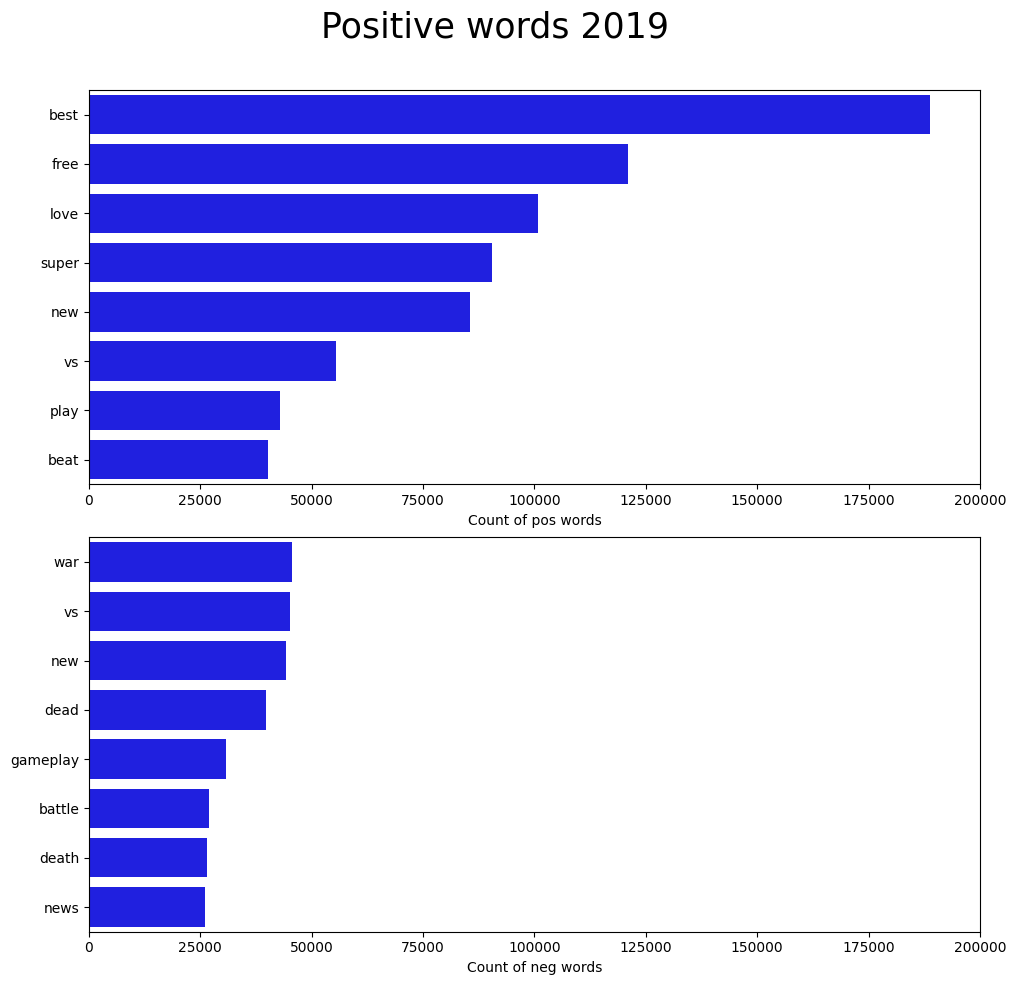

In [94]:
YEAR = 2019
plot_words(YEAR, pos_freq_2019, neg_freq_2019, 200000)

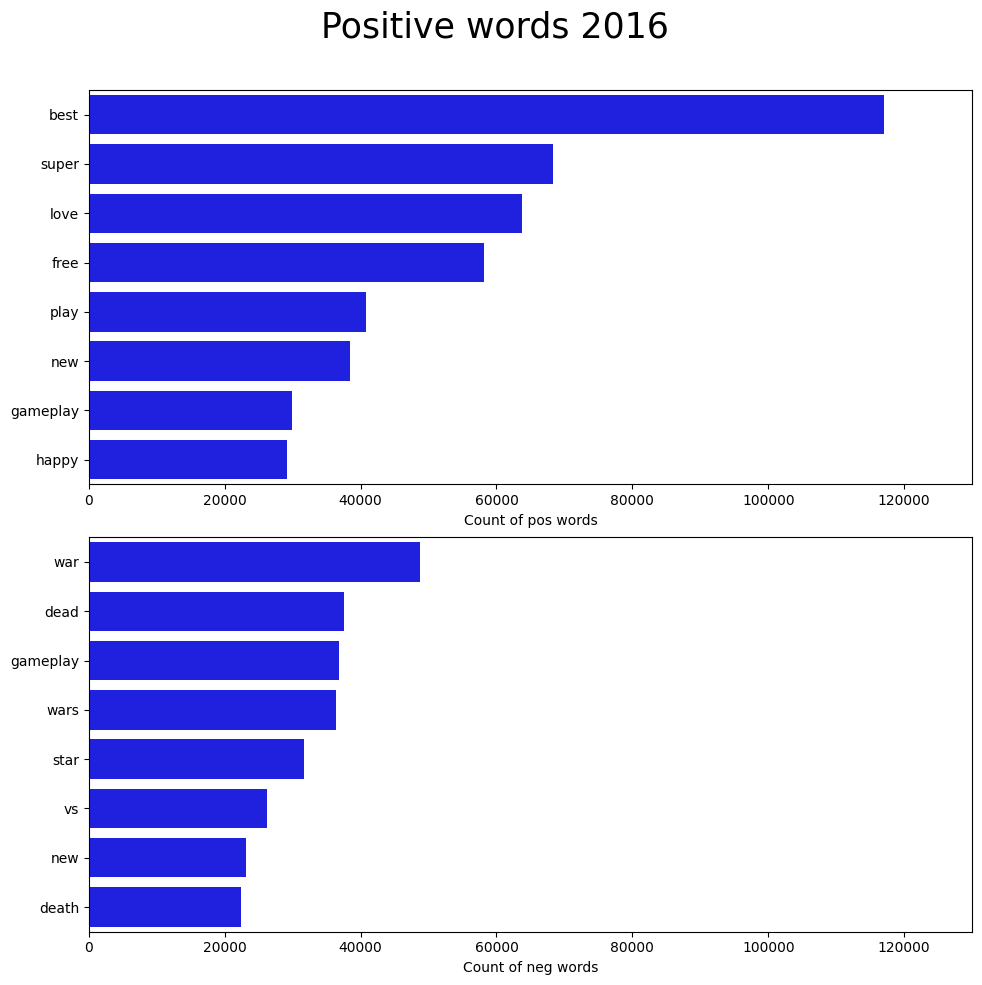

In [96]:
YEAR = 2016
plot_words(YEAR, pos_freq_2016, neg_freq_2016, 130000)

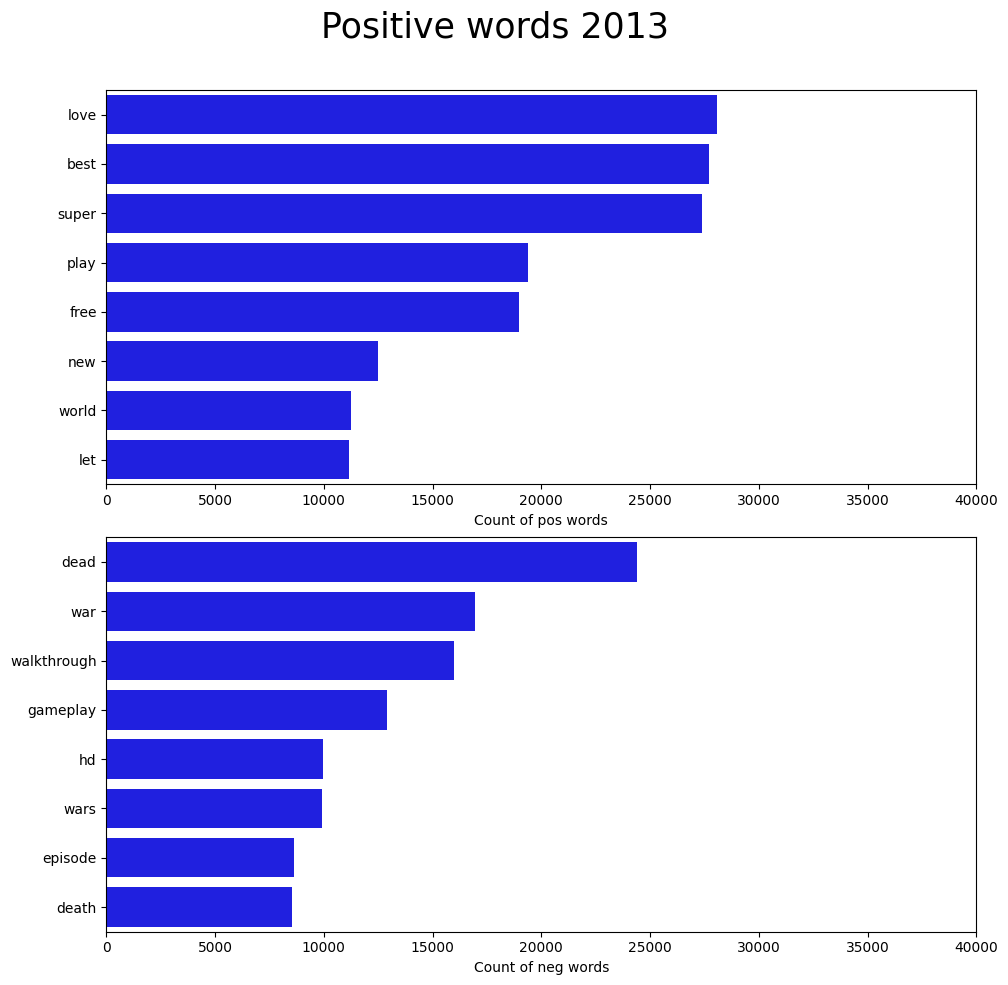

In [98]:
YEAR = 2013
plot_words(YEAR, pos_freq_2013, neg_freq_2013, 40000)

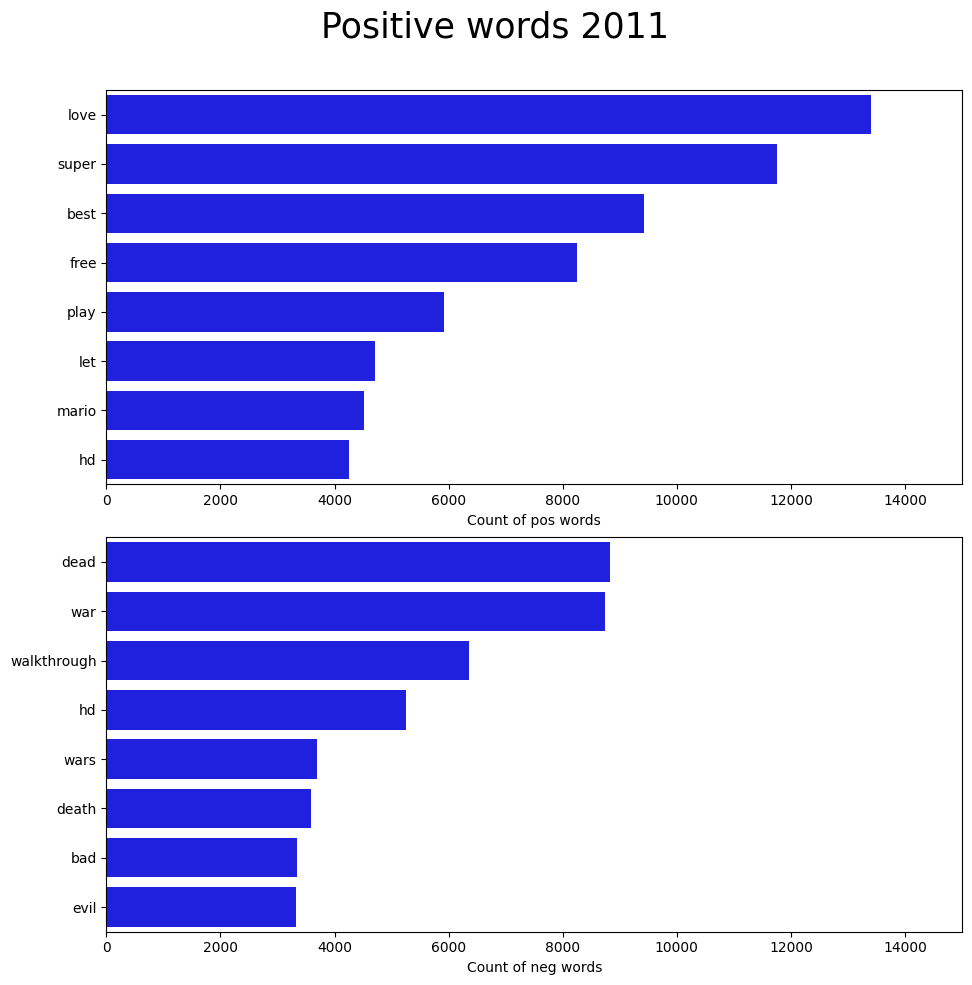

In [101]:
YEAR = 2011
plot_words(YEAR, pos_freq_2011, neg_freq_2011, 15000)

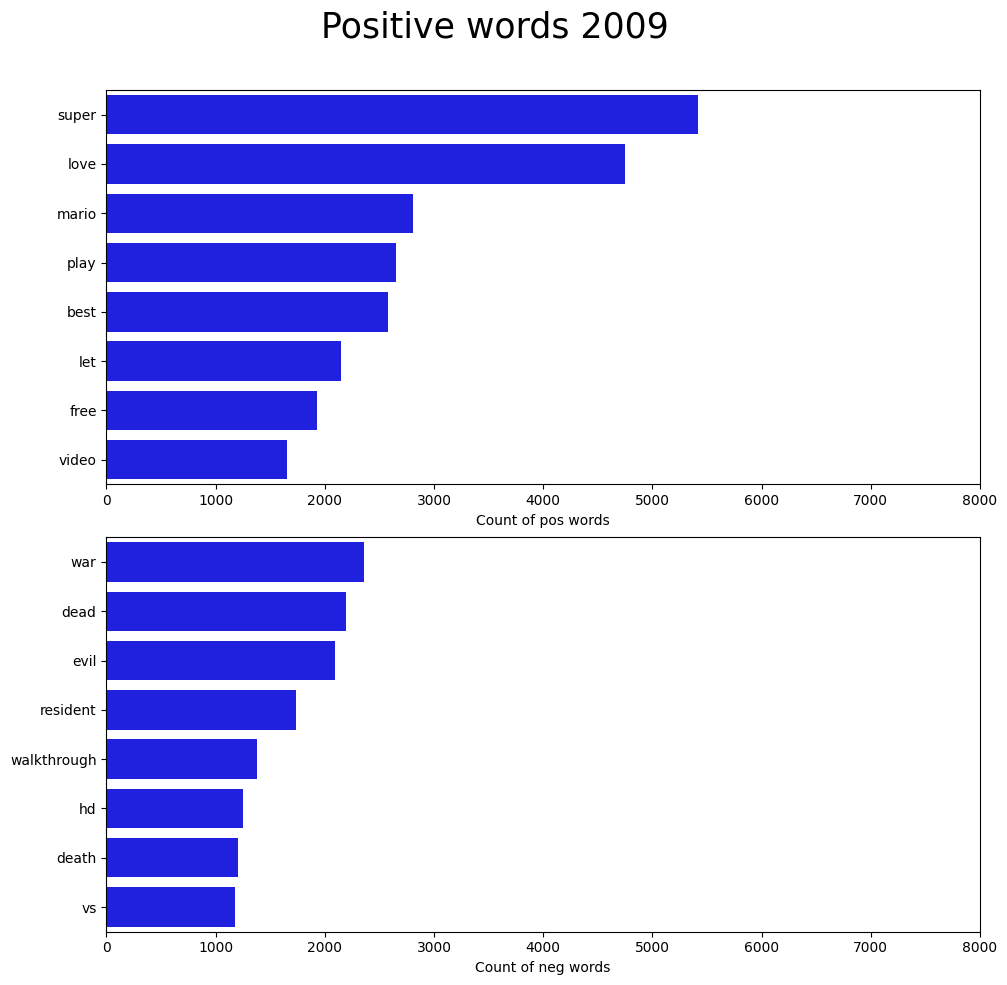

In [103]:
YEAR = 2009
plot_words(YEAR, pos_freq_2009, neg_freq_2009, 8000)

### 1.3 Exact Matching

(Unreal to do it with the huge dataset we have)

In [105]:
# Separate the treatment and control groups
# pos_df = df_merged[df_merged['label'] == 1].sample(frac=1) # randomizing the order of the nodes - will not change the results
# neg_df = df_merged[df_merged['label'] == -1].sample(frac=1)

# df_merged = df.parallel_apply(polarity_score, axis = 1)

# Create an empty undirected graph for solving this task
eps = 600 # sec
years = [2010, 2014, 2019]

# choosing the most popular video in YouTube because we want to explore the connection between
df_merged = df_merged[df_merged['upload_year'].isin(years)].sort_values(by=['view_count'], ascending=False)[:int(len(df_merged)*0.01)]

U = []
for y in years:
    print(y)
    G_match = nx.Graph()
    pos_df = df_merged[(df_merged['label'] == 1) & (df_merged['upload_year'] == y)].sample(frac=1) # randomizing the order of the nodes - will not change the results
    neg_df = df_merged[(df_merged['label'] == -1) & (df_merged['upload_year'] == y)].sample(frac=1)
    for pos_id, pos_row in pos_df.iterrows():
        for neg_id, neg_row in neg_df.iterrows():
            # the similarity by the author 'settings like categoriy, duration and in addition upload year.
            if pos_row['categories'] == neg_row['categories'] and abs(pos_row['duration'] - neg_row['duration']):
                G_match.add_edge(pos_id, neg_id)

    U.append(nx.max_weight_matching(G_match))

matching = set().union(*U)

In [ ]:
matched = [a for a, b in list(matching)] + [b for a, b in list(matching)]
matches = df_merged.loc[matched]
print(f"Number of matched pairs: {len(matches)/2 :0.0f}")
matches.sort_values(by = 'upload_year').head(5)

In [ ]:
for i in years:
    ax = sns.histplot(matches[(matches.label == 1) & (matches.upload_year == i)]['view_count'], kde=True, stat='density', color='blue', label='pos', log=True)
    ax = sns.histplot(matches[(matches.label == -1) & (matches.upload_year == i)]['view_count'], kde=True, stat='density', color='orange', label='neg', log=True)
    ax.set(title=f'View distribution comparison in {i}, after matching', xlabel=f'View count in {i}', ylabel='Like density')
    ax.set(xlim=(1, 1e7))
    plt.legend()
    plt.show();

In [ ]:
# Now we saw that positive or negative content prevails at some number of views
# Let's see what the title is negative / positive and see the number of views they have!

matches[(matches.view_count > 1) & (matches.view_count < 0.1* 1e7) & (matches.upload_year == years[0])][['label', 'title', 'view_count']].sort_values('view_count', ascending=False)

# 3 Graph Creation

The aim of this method is to create a graph that will represent the connection among videos using common tags using NetworkX.

Using this approach, we could see if there is a tendency of Youtube that the content of videos becomes more specific and diverse.

### 3.1 Data processing

In [9]:
%%time

# Select a year
YEAR = 2015
graph = pd.read_feather("yearly_wo_desc/2015_yt_metadata_wo_desc_dislike.feather")
graph = graph.drop(["duration", "like_count"], axis=1)
# choosing the most popular video in YouTube because we want to explore the connection between
graph = graph.sort_values(by=['view_count'], ascending=False)[:int(len(graph)*0.01)] #*0.005

# Preparing the tags to be split using CountVectorizer. 
# Here we get rid of the possible spans around commas in the tags and replace the white spaces with the "_" (e.g. "Champions League" -> "Champions_League")
def prepare_tags(tag):
    tag=tag.replace(', ', ',').replace(' ,',',').replace(' , ',',')
    tag = tag.replace(" ", "_")
    return tag

CPU times: user 15.7 s, sys: 7.1 s, total: 22.8 s
Wall time: 20.2 s


In [10]:
%%time 

# Let's count the number of tags in videos
def count_tags(tag):
    return len(tag.split(","))

graph['count_tags'] = graph.tags.apply(count_tags)
print(f"The max number of tags in videos in {YEAR} is:", graph.count_tags.max())

The max number of tags in videos in 2015 is: 91
CPU times: user 127 ms, sys: 714 µs, total: 128 ms
Wall time: 127 ms


In [11]:
%%time
# Converting a collection of tags to a matrix of token counts.
def conv_to_matrix(data, min_df=1, max_df=1.0):
    vectorizer = CountVectorizer(tokenizer=lambda x: x.split(','), strip_accents='ascii', lowercase=True, min_df=min_df, max_df=max_df)
    X = vectorizer.fit_transform([data.iloc[i].tags for i in range(len(data))])
    return X[: , 1:], vectorizer.get_feature_names_out()[1:]

tags_matrix, tags_list = conv_to_matrix(graph, min_df=100)

CPU times: user 7.29 s, sys: 92.5 ms, total: 7.39 s
Wall time: 7.38 s


In [12]:
# Getting rid of non-Latin characters in the tags to avoid the minority of Chinese, Russian ... char 
# by hand
def is_latin(uchr):
    try: 
        latin_letters= {}
        return latin_letters[uchr]
    except KeyError:
        return latin_letters.setdefault(uchr, 'LATIN' in ud.name(uchr))

def only_roman_chars(unistr):
    return all(is_latin(uchr) for uchr in unistr if uchr.isalpha())

def del_non_latin(tags_list, tags_matrix):
    to_delete=[]
    for i in range(len(tags_list)):
        if only_roman_chars(tags_list[i]) == False:
            to_delete.append(i)
    tags_list = np.delete(tags_list, to_delete)
    tags_matrix = np.delete(tags_matrix, to_delete, axis=1)
    return tags_list, tags_matrix

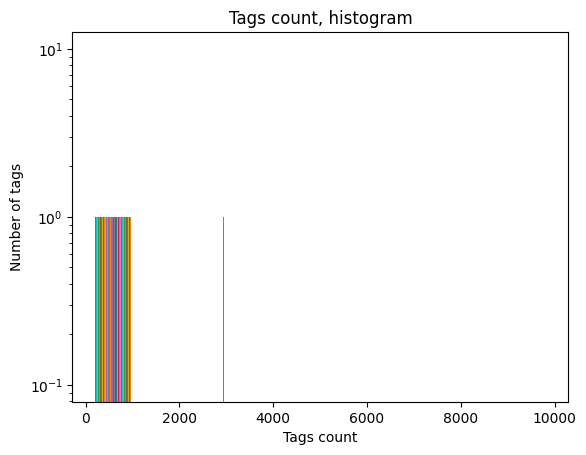

In [13]:
plt.hist(np.sort(tags_matrix.sum(axis=0)), log=True)
plt.xlabel('Tags count')
plt.ylabel('Number of tags')
plt.title('Tags count, histogram')
plt.show();

For the proper connection analysis and simplicity, we need to remove the least-used and most-used tags.

min_df = "ignore terms that appear in less than n % of the documents"

max_df = "ignore terms that appear in more than (1-n) % of the documents".

In [14]:
# if change
tags_matrix, tags_list = conv_to_matrix(graph, min_df = 100)
print("Number of tags after filtering out least-used and most-used tags: ", tags_matrix.shape[1])

Number of tags after filtering out least-used and most-used tags:  1713


In [15]:
# check the filtering 
len(np.argwhere(np.sum(tags_matrix, axis=0) < 100))

0

In [16]:
%%time

display_id = graph.display_id.values
channel_id = graph.channel_id.values

print("Number of channels: ", len(np.unique(channel_id)))
print("Number of videos: ", tags_matrix.shape[0])

from cython.parallel import prange

tag = 0
unique_tag = pd.DataFrame(columns=['cannel_id', 'tag', 'count_tags'])
for i in prange(tags_matrix.shape[1], nogil=True):
    dt = np.argwhere(tags_matrix[:, i]>0)[:, 0]
    channels = np.unique(channel_id[dt])
    if len(channels) == 1:
        tag+=1
print("Number of tags that are used only in a specific channel: ", tag)

Number of channels:  12322
Number of videos:  68080
Number of tags that are used only in a specific channel:  96
CPU times: user 9.09 s, sys: 2.84 ms, total: 9.09 s
Wall time: 9.09 s


In [17]:
# We started from the kittens. Let's look if there are some tags in the top 5% of the videos and save its position.
id_tag_list = np.argwhere(tags_list=='kitten')[0][0]

vid_kittens = display_id[np.argwhere(tags_matrix[:, id_tag_list]>0)[:, 0]]

Some channels use more than one unique tag over their videos. Since we will represent the nodes as a video id and the edges as tags that connect them, we shouldn't include tags which are used only by one specific channel in the graph because it won't let us show the clustering tendency.

### 3.2 Creation of the graph

In [18]:
%%time
from multiprocessing import Pool

attributes = []
def comb():
    res = list(itertools.combinations(attributes, 2)) # create a list from the iterator
    return res

def Create_Graph(tags_matrix, tags_list, channel_id, display_id):
    G = nx.Graph()
    for tag in range(tags_matrix.shape[1]):
        vid = np.argwhere(tags_matrix[:, tag]>0)[:, 0]
        count_unique_channels = np.unique(channel_id[vid])
        if len(count_unique_channels) != 1: # filtering out tags which appeared in only one channel
            if len(vid) > 1:
                comb_ = list(itertools.combinations(display_id[vid], 2))
                for i in comb_:
                    if G.has_edge(*(i[0], i[1])):
                        G[i[0]][i[1]]['weight'] +=1
                        # G[i[0]][i[1]]['value'].append(tags_list[tag])
                    else:
                        G.add_edge(i[0], i[1], weight=1) # value=[tags_list[tag]]
    return G
G = Create_Graph(tags_matrix, tags_list, channel_id, display_id)

CPU times: user 7min 32s, sys: 1min 7s, total: 8min 40s
Wall time: 8min 40s


In [19]:
print(f"There are {G.number_of_nodes()} nodes and {G.number_of_edges()} edges present in the Graph")

There are 57582 nodes and 158993000 edges present in the Graph


In [20]:
# Saving the graph
from community import community_louvain


def drop_weights(G):
    '''Drop the weights from a networkx weighted graph.'''
    G_copy = G.copy()
    for node, edges in nx.to_dict_of_dicts(G_copy).items():
        for edge, attrs in edges.items():
            attrs.pop('weight', None)
    return G_copy

def mapping(x):return int(x)

def save(G, output):
    # right format
    G_copy = drop_weights(G)
    G_copy = nx.convert_node_labels_to_integers(G_copy, first_label=1, ordering='default', label_attribute="name") # change to '' for web
    val = [f"id{i}" for i in range(1, len(G.nodes)+1)]
    key =  [i for i in range(1, len(G.nodes)+1)]
    mapping = {key[i]: val[i] for i in range(len(key))}
    G_copy = nx.relabel_nodes(G_copy, mapping)
    label = community_louvain.best_partition(G_copy)
    mod = community_louvain.modularity(label, G_copy)
    values = [label.get(node) for node in G_copy.nodes()]
    nx.set_node_attributes(G_copy, {val[i]: values[i] for i in range(len(key))}, "color")
    lst3 = list(set(vid_kittens) & set(nx.get_node_attributes(G_copy, 'name').values())) # where kittens
    # save
    with open(output, 'w') as outfile1:
        outfile1.write(json.dumps(dict(json_graph.node_link_data(G_copy))))

def read_json_file(input):
    with open(input) as f:
        js_graph = json.load(f)
    return json_graph.node_link_graph(js_graph)

In [58]:
# save(G, f'networkdata{YEAR}.json')

In [59]:
# G = read_json_file(f'networkdata{YEAR}.json')

### 3.3 Graph pruning

- Filtering out rare connections.
When two videos are linked only once, the edge's presence in the graph is less significant. We chose to exclude connections between videos that had fewer than 10 tags connecting them from vizualizations.
- Removing isolates and small components
This tag dataset is very sparse.
We chose to exclude fewer connected components from the graph for data size and legibility concerns, as well as we are more interested connections between the videos.


In [21]:
def filtering(Graph, E_min):
    # E_min = 2
        
    to_remove =[]
    for (e1, e2, val) in Graph.edges.data('weight'):
        # print((e1, e2, val))
        if val < E_min:
            to_remove.append((e1,e2))
            
    print("Number of edges that will be removed", len(to_remove))
    Graph.remove_edges_from(to_remove)
    return Graph

G = filtering(G, 20)

Number of edges that will be removed 158721133


In [22]:
def removing(Graph, nodes):
    # nodes = 3

    Graph.remove_nodes_from(list(nx.isolates(Graph))) # remove isolates

    to_remove = []
    for comp in nx.connected_components(Graph):
        if len(comp) < nodes:
            to_remove.append(comp)

    print("Number of components that will be removed", len(to_remove))
    for comp in to_remove:
        Graph.remove_nodes_from(comp)
    return Graph

G = removing(G, 15)

Number of components that will be removed 176


In [62]:
save(G, f'networkdata{YEAR}.json')

### 3.4 Graph analysis

In [23]:
degrees = [v for (n, v) in G.degree()]
print(f"The maximum degree of the Graph is {np.max(degrees)}")   
print(f"The minimum degree of the Graph is {np.min(degrees)}")

The maximum degree of the Graph is 501
The minimum degree of the Graph is 1


In [24]:
print(f"The average degree of the nodes in the Graph is {np.mean(degrees):.1f}")  
print(f"The most frequent degree of the nodes found in the Graph is {stats.mode(degrees)[0][0]}") 

The average degree of the nodes in the Graph is 143.1
The most frequent degree of the nodes found in the Graph is 259


In [25]:
if nx.is_connected(G):
    print("The graph is connected")
else:
    print("The graph is not connected")
    
print(f"There are {nx.number_connected_components(G)} connected components in the Graph") 
size = np.sort([len(c) for c in nx.connected_components(G)])
print('Component sizes:', size)

The graph is not connected
There are 35 connected components in the Graph
Component sizes: [  15   15   16   17   22   23   23   29   32   32   34   35   38   44
   45   49   52   53   55   59   61   65   66  106  110  120  129  131
  157  186  193  205  260  266 1035]


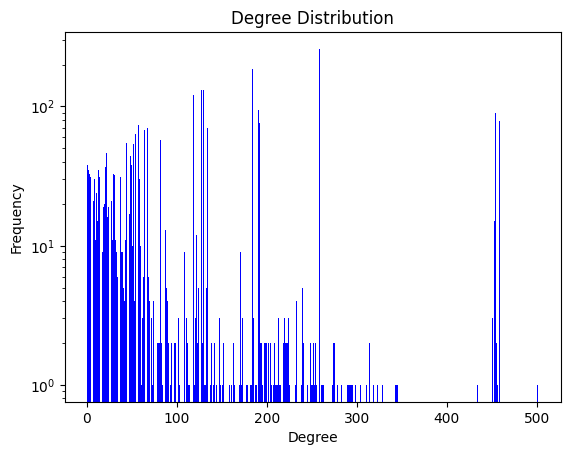

In [26]:
def plot_degree_distribution(G):
    degrees = {}
    for node in G.nodes():
        degree = G.degree(node)
        if degree not in degrees:
            degrees[degree] = 0
        degrees[degree] += 1
    sorted_degree = sorted(degrees.items())
    deg = [k for (k,v) in sorted_degree]
    cnt = [v for (k,v) in sorted_degree]
    
    plt.bar(deg, cnt, log = True, color='blue')
    plt.title("Degree Distribution")
    plt.ylabel("Frequency")
    plt.xlabel("Degree")
    plt.show();
     

degree = plot_degree_distribution(G)

In [27]:
%%time

largest_subgraph = max((G.subgraph(c) for c in nx.connected_components(G)), key=len)     
print(f"There are {largest_subgraph.number_of_nodes()} nodes and {largest_subgraph.number_of_edges()} edges present in the largest component of the Graph")

There are 1035 nodes and 133120 edges present in the largest component of the Graph
CPU times: user 253 ms, sys: 124 µs, total: 253 ms
Wall time: 252 ms


In [28]:
# To explore the the tendency of the nodes to cluster together we want to see he transitivity or clustering coefficient of a network.
# The density is close to 0 may be because the graph is disconnected.
print(f"The transitivity of the graph is {nx.transitivity(G)}")
print(f"The density of the graph is {nx.density(G)}")

The transitivity of the graph is 0.9723361445990103
The density of the graph is 0.03788820720212739


### 3.5 Graph plotting 

We may now view the Graph's appearance. In order to draw the graph, we will use node positioning methods(nx.drawing.layout package). Specifically, we will use spring_layout which uses force-directed graph drawing whose purpose is to position the nodes in two-dimensional space so that all the edges are of equal length and as few crossing edges as possible. 

Also, the colour of the nodes will represent the communities the node belongs to. The problem of detecting this community structure of the graph is one of the outstanding issues in the study of networked systems. One highly effective approach is the optimization of the quality function known as “modularity” over the possible divisions of a network.

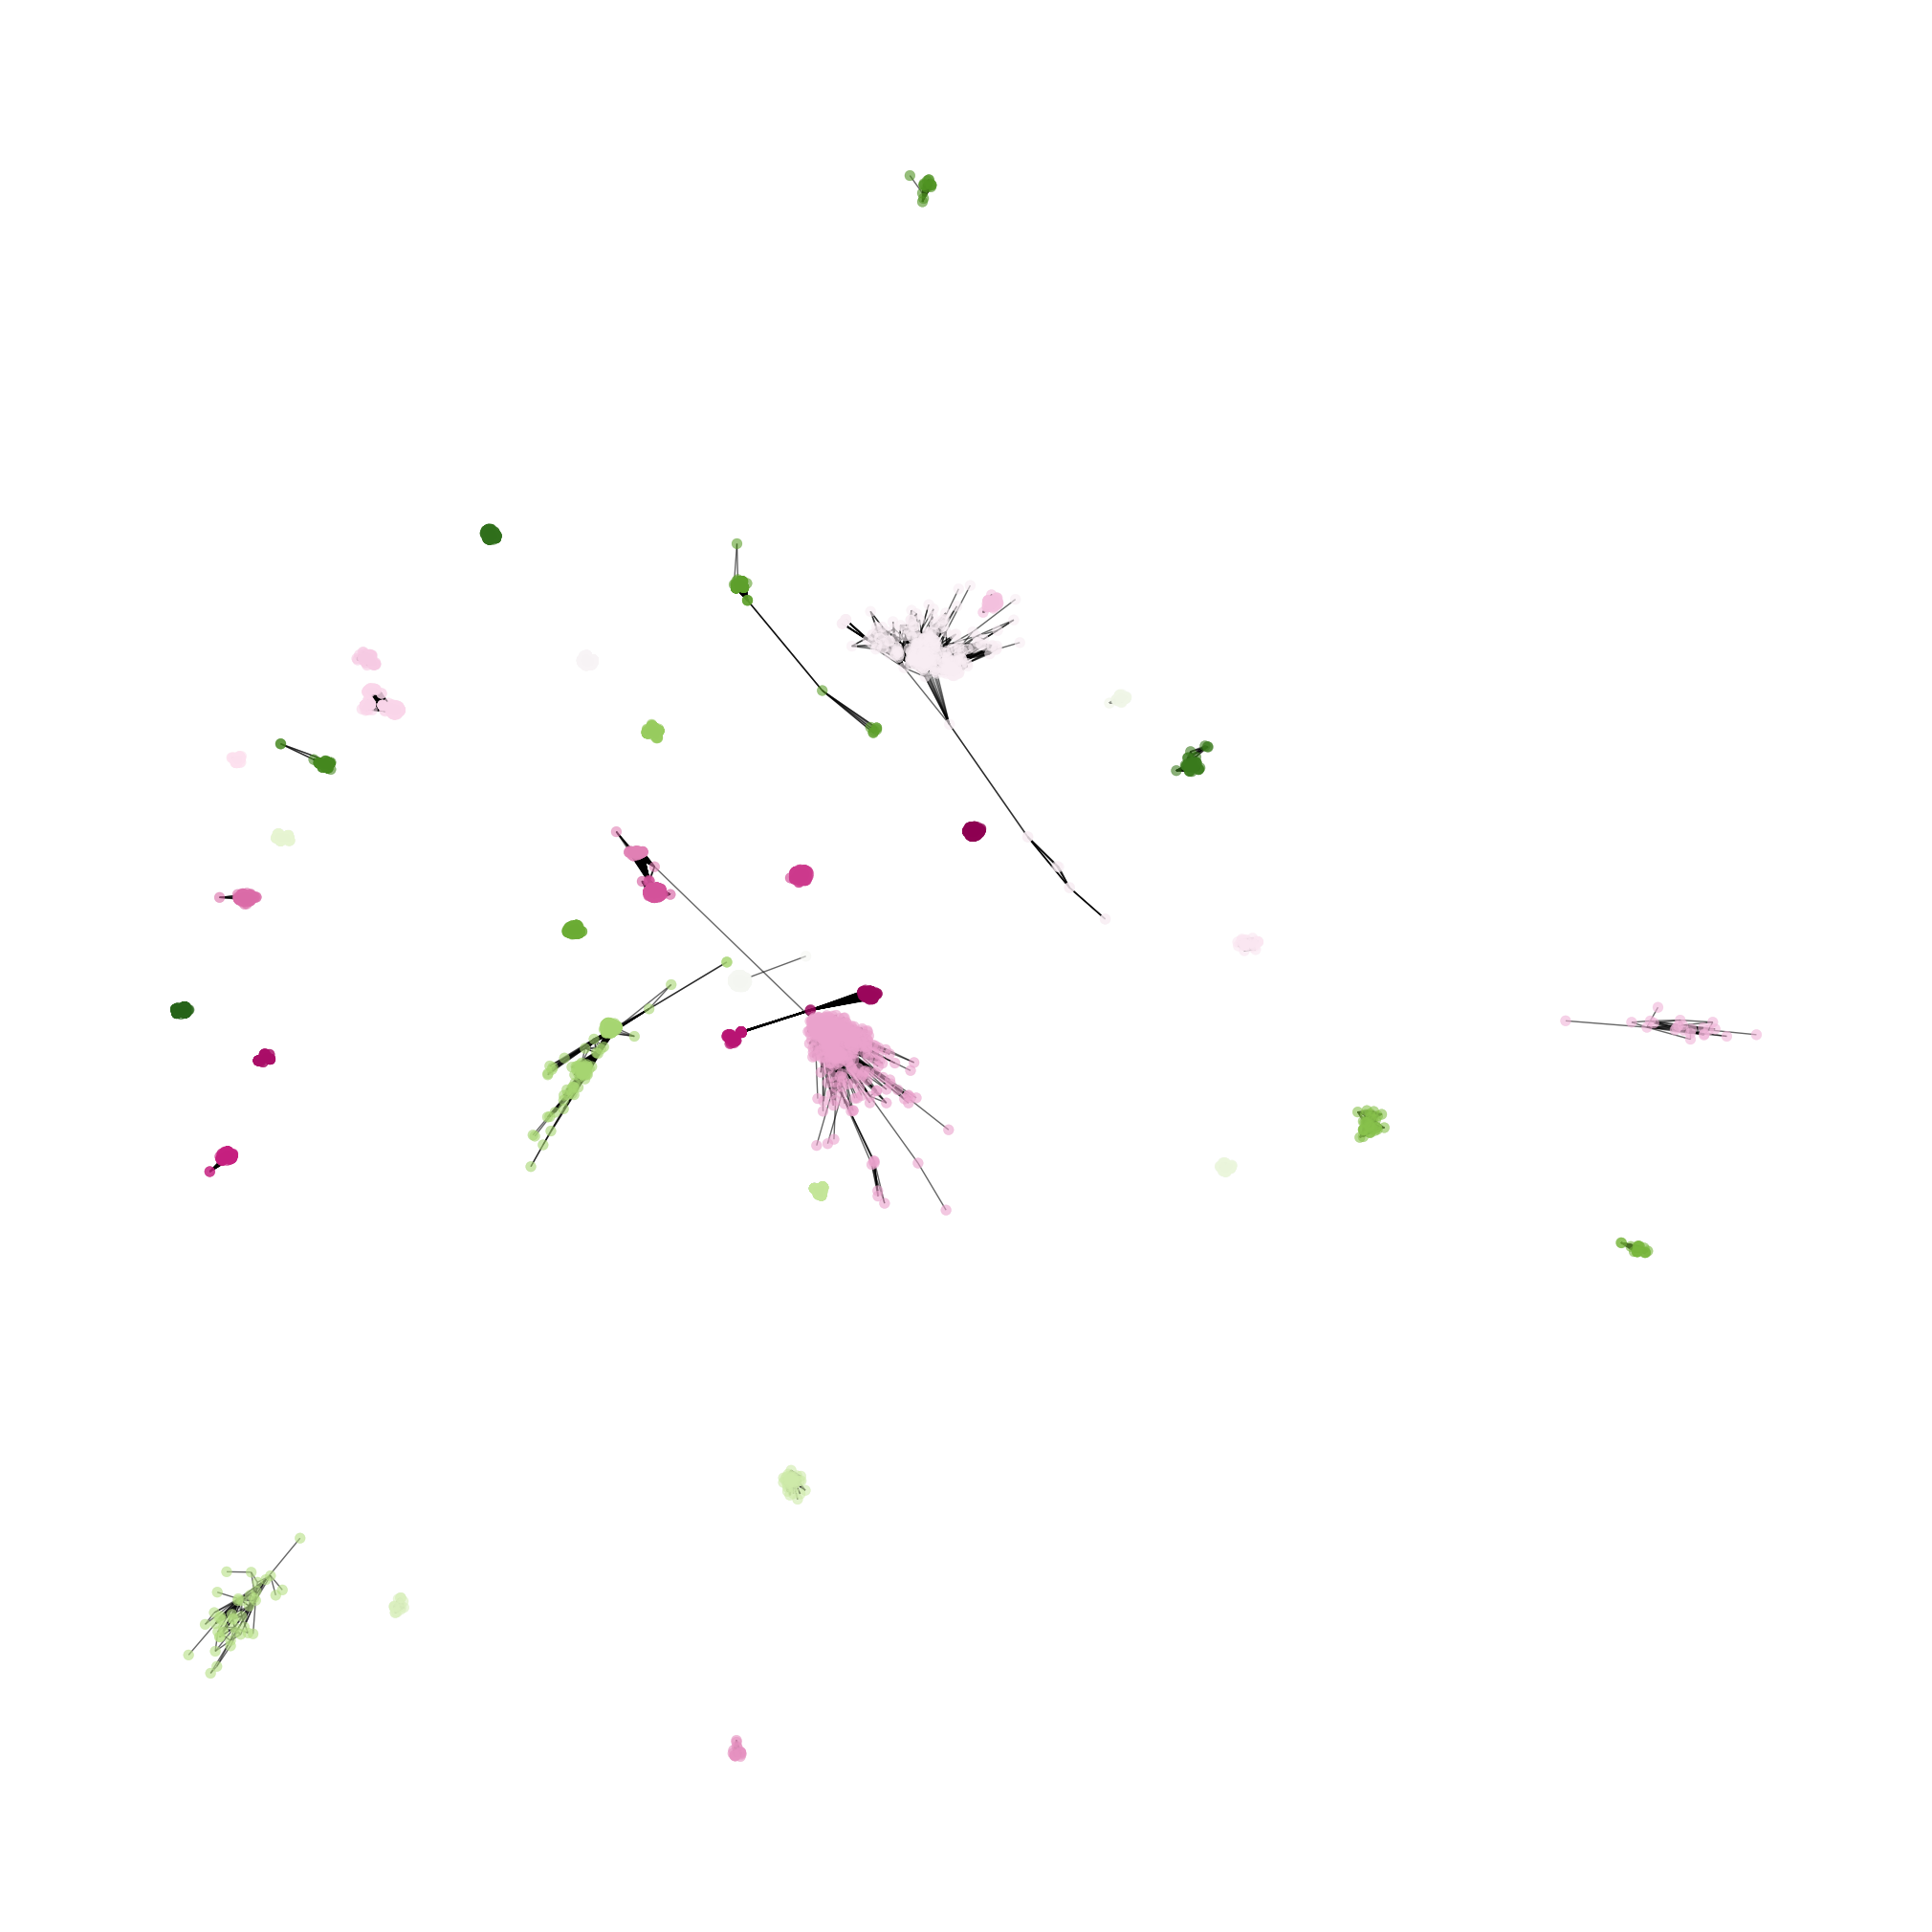

In [69]:
def draw_graph(year, Graph):
    node_and_degree = Graph.degree()
    pos = nx.spring_layout(Graph, k=0.05, weight='weight')

    label = community_louvain.best_partition(Graph)
    mod = community_louvain.modularity(label, Graph)
    values = [label.get(node) for node in Graph.nodes()]

    plt.figure(figsize = (20,20))
    nx.draw(Graph, pos=pos, node_color=values, cmap=plt.cm.PiYG, edge_color="black", linewidths=0.3, node_size=60, alpha=0.6, with_labels=False)
    plt.savefig(f'graph{year}.png')
    plt.show();

draw_graph(YEAR, G)

In [70]:
# We may assume that the central node of the component satisfies the notion of popularity, 
# and the video might be recommended to the majority of viewers on YouTube.
# To check this and the trends in a specific year, we will compute the Katz centrality score and look onto the view and like counts.
def central_info(Graph, max, min):
    S = [Graph.subgraph(c).copy() for c in nx.connected_components(Graph)]
    df_central = pd.DataFrame(columns=['title', 'display_id', 'view_count'])
    for i in S:
        degree_centrality_df = pd.DataFrame(nx.katz_centrality_numpy(i).items(), columns=["node", "degree_centrality"])
        most = degree_centrality_df.sort_values("degree_centrality", ascending=False).iloc[max]
        # less = degree_centrality_df.sort_values("degree_centrality", ascending=False).iloc[min]
        df_central = df_central.append(graph.loc[graph.display_id == most.node][['title', 'display_id', 'view_count']], ignore_index=False) 
        # df_central = df_central.append(graph.loc[graph.display_id == less.node][['tags', 'display_id', 'view_count']], ignore_index=False)
        
    return df_central

central_info(G, 0, 3)

,title,display_id,view_count
3982601,Little Baby Bum | Dancing Songs | Nursery Rhym...,H9MZkxBH4Hk,6234187.0
317881,Suryaputra Karn - सूर्यपुत्र कर्ण - Episode 96...,l6BaUO1PBbo,2819552.0
1531575,Barbie Vending Machine of Shopkins Season 3 wi...,r18dWZbC3bY,12306093.0
317886,Bharat Ka Veer Putra Maharana Pratap - महाराणा...,1CVBR164dGw,3170310.0
319143,Adaalat - अदालत - Jurassic Jazeera - Episode 4...,LOulRugldRM,2924420.0
315281,Minecraft: HALLOWEEN THEME PARK HUNGER GAMES -...,c_JXq0TW-xU,2901287.0
633446,iPhone 6 Dropped Inside a Lava Lamp!,cUMPwByVpww,19119538.0
2645509,NUMBERJACKS | Hundreds And Thousands | S2E20,_vVVvebxplA,9239308.0
1069032,✔ Minecraft: 10 Things You Didn't Know About t...,UBKwAalmNJk,2991185.0
3911678,Vanoss Gaming Funny Moments - Best Moments of ...,lonWqxXS_tQ,43547664.0


### 3.6 Circle graph of connected categories of the videos
Here we want to see how the categories of the videos are connected with each other, assuming that there are no precise divisions into categories(the category may not describe the content exactly, since each video has only one category).

In [71]:
graph.categories.value_counts()

Entertainment            18428
Music                    13139
Gaming                   10630
Film & Animation          5541
People & Blogs            4270
Comedy                    3845
Education                 3594
Howto & Style             2812
Sports                    1901
Science & Technology      1126
News & Politics            952
Autos & Vehicles           654
Pets & Animals             613
Travel & Events            417
Nonprofits & Activism      157
                             1
Name: categories, dtype: int64

In [72]:
# connection between categories
categ = graph.categories.values 

def categories_connection(G, display_id):
    connection_G = nx.Graph()
    for v,n in G.edges:
        categ1 = categ[np.argwhere(display_id==v)[0]][0]
        categ2 = categ[np.argwhere(display_id==n)[0]][0]
        if categ1 != categ2:
            if connection_G.has_edge(*(categ1, categ2)):
                connection_G[categ1][categ2]['weight'] +=1
            else:
                connection_G.add_edge(categ1, categ2, weight = 1)
    return connection_G

connection_G = categories_connection(G, display_id)
print(f"There are {connection_G.number_of_nodes()} nodes and {connection_G.number_of_edges()} edges present in the Graph")

There are 8 nodes and 12 edges present in the Graph


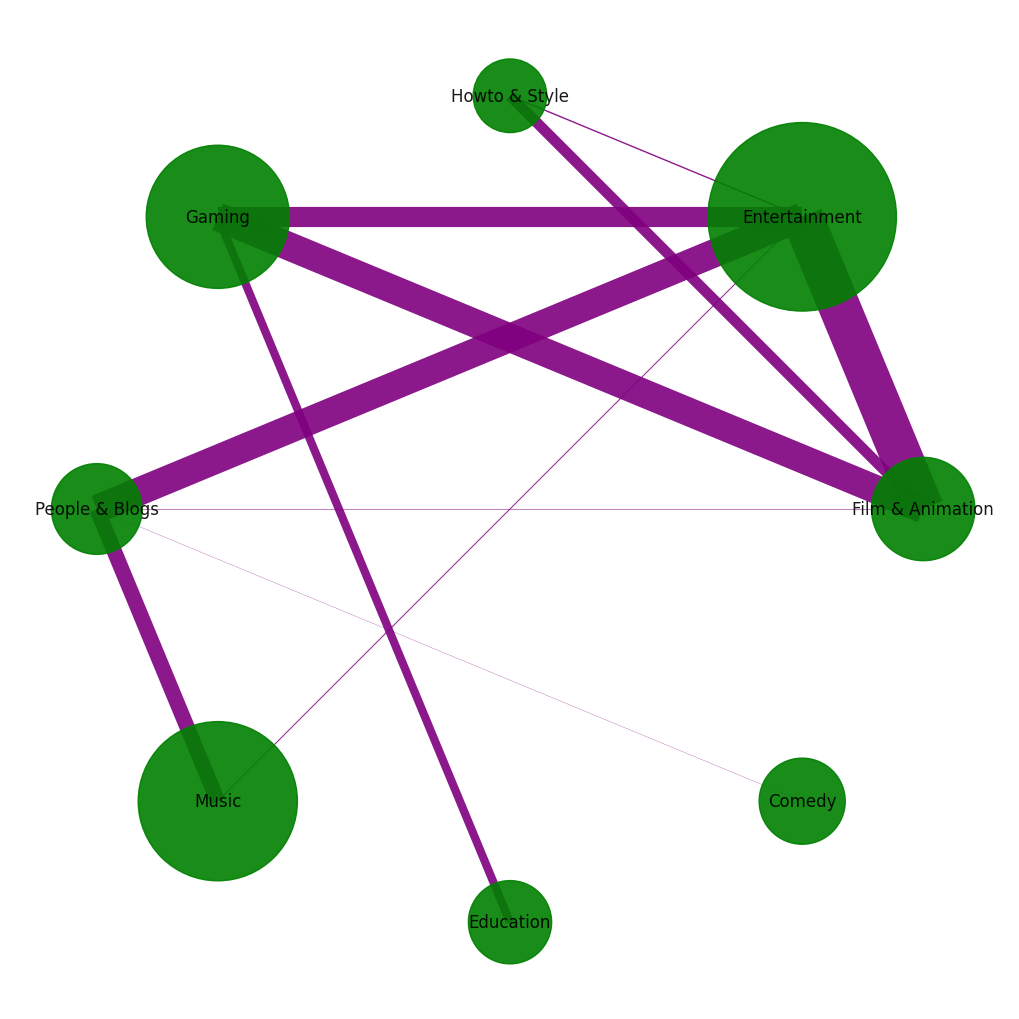

In [73]:
def category_connection(year, connection, df, w1, w2):
    weights = np.array([connection[u][v]['weight'] for u,v in connection.edges()])
    weights = (weights - np.min(weights)) / (np.max(weights)-np.min(weights))
    node_size = np.array([df.categories.value_counts()[i] for i in connection.nodes()])
    plt.figure(figsize = (10,10))
    nx.draw_circular(connection, with_labels=True,  node_color='g', edge_color = 'purple', alpha = 0.9, width=weights*w1, node_size=node_size*w2)
    plt.savefig(f'graph_connection{year}.png')
    plt.show();
    
category_connection(YEAR, connection_G, graph, 30, 1)

### 3.7 Comparison

Let's see what result we might get from other years

#### 2009

The max number of tags in videos in 2009 is: 92
Number of channels:  2750
Number of videos:  13891
There are 11300 nodes and 9492088 edges present in the Graph
Number of edges that will be removed 9486888
Number of components that will be removed 11
The maximum degree of the Graph is 115
The minimum degree of the Graph is 1
The average degree of the nodes in the Graph is 50.9
The most frequent degree of the nodes found in the Graph is 96
The graph is not connected
There are 3 connected components in the Graph
Component sizes: [ 11  14 177]


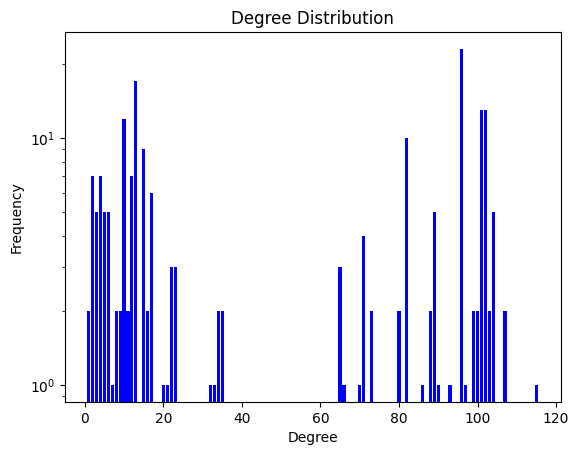

CPU times: user 46.7 s, sys: 3.77 s, total: 50.4 s
Wall time: 50.1 s


In [36]:
%%time

# prepare data
YEAR = 2009
graph = pd.read_feather("yearly_wo_desc/2009_yt_metadata_wo_desc_dislike.feather")
graph = graph.drop(["duration", "like_count"], axis=1)
# choosing the most popular video in YouTube because we want to explore the connection between
graph = graph.sort_values(by=['view_count'], ascending=False)[:int(len(graph)*0.02)] #0.01
graph.tags = graph.tags.apply(prepare_tags)
graph['count_tags'] = graph.tags.apply(count_tags)
print(f"The max number of tags in videos in {YEAR} is:", graph.count_tags.max())

tags_matrix, tags_list = conv_to_matrix(graph, min_df = 100)
display_id = graph.display_id.values
channel_id = graph.channel_id.values
print("Number of channels: ", len(np.unique(channel_id)))
print("Number of videos: ", tags_matrix.shape[0])
# Graph creation
G = Create_Graph(tags_matrix, tags_list, channel_id, display_id)
print(f"There are {G.number_of_nodes()} nodes and {G.number_of_edges()} edges present in the Graph")

G = filtering(G, 18)
G = removing(G, 10)
save(G, f'networkdata{YEAR}.json')

# Graph analysis
degrees = [v for (n, v) in G.degree()]
print(f"The maximum degree of the Graph is {np.max(degrees)}")   
print(f"The minimum degree of the Graph is {np.min(degrees)}")
print(f"The average degree of the nodes in the Graph is {np.mean(degrees):.1f}")  
print(f"The most frequent degree of the nodes found in the Graph is {stats.mode(degrees)[0][0]}") 
if nx.is_connected(G):
    print("The graph is connected")
else:
    print("The graph is not connected")
    
print(f"There are {nx.number_connected_components(G)} connected components in the Graph") 
size = np.sort([len(c) for c in nx.connected_components(G)])
print('Component sizes:', size)

degree = plot_degree_distribution(G)

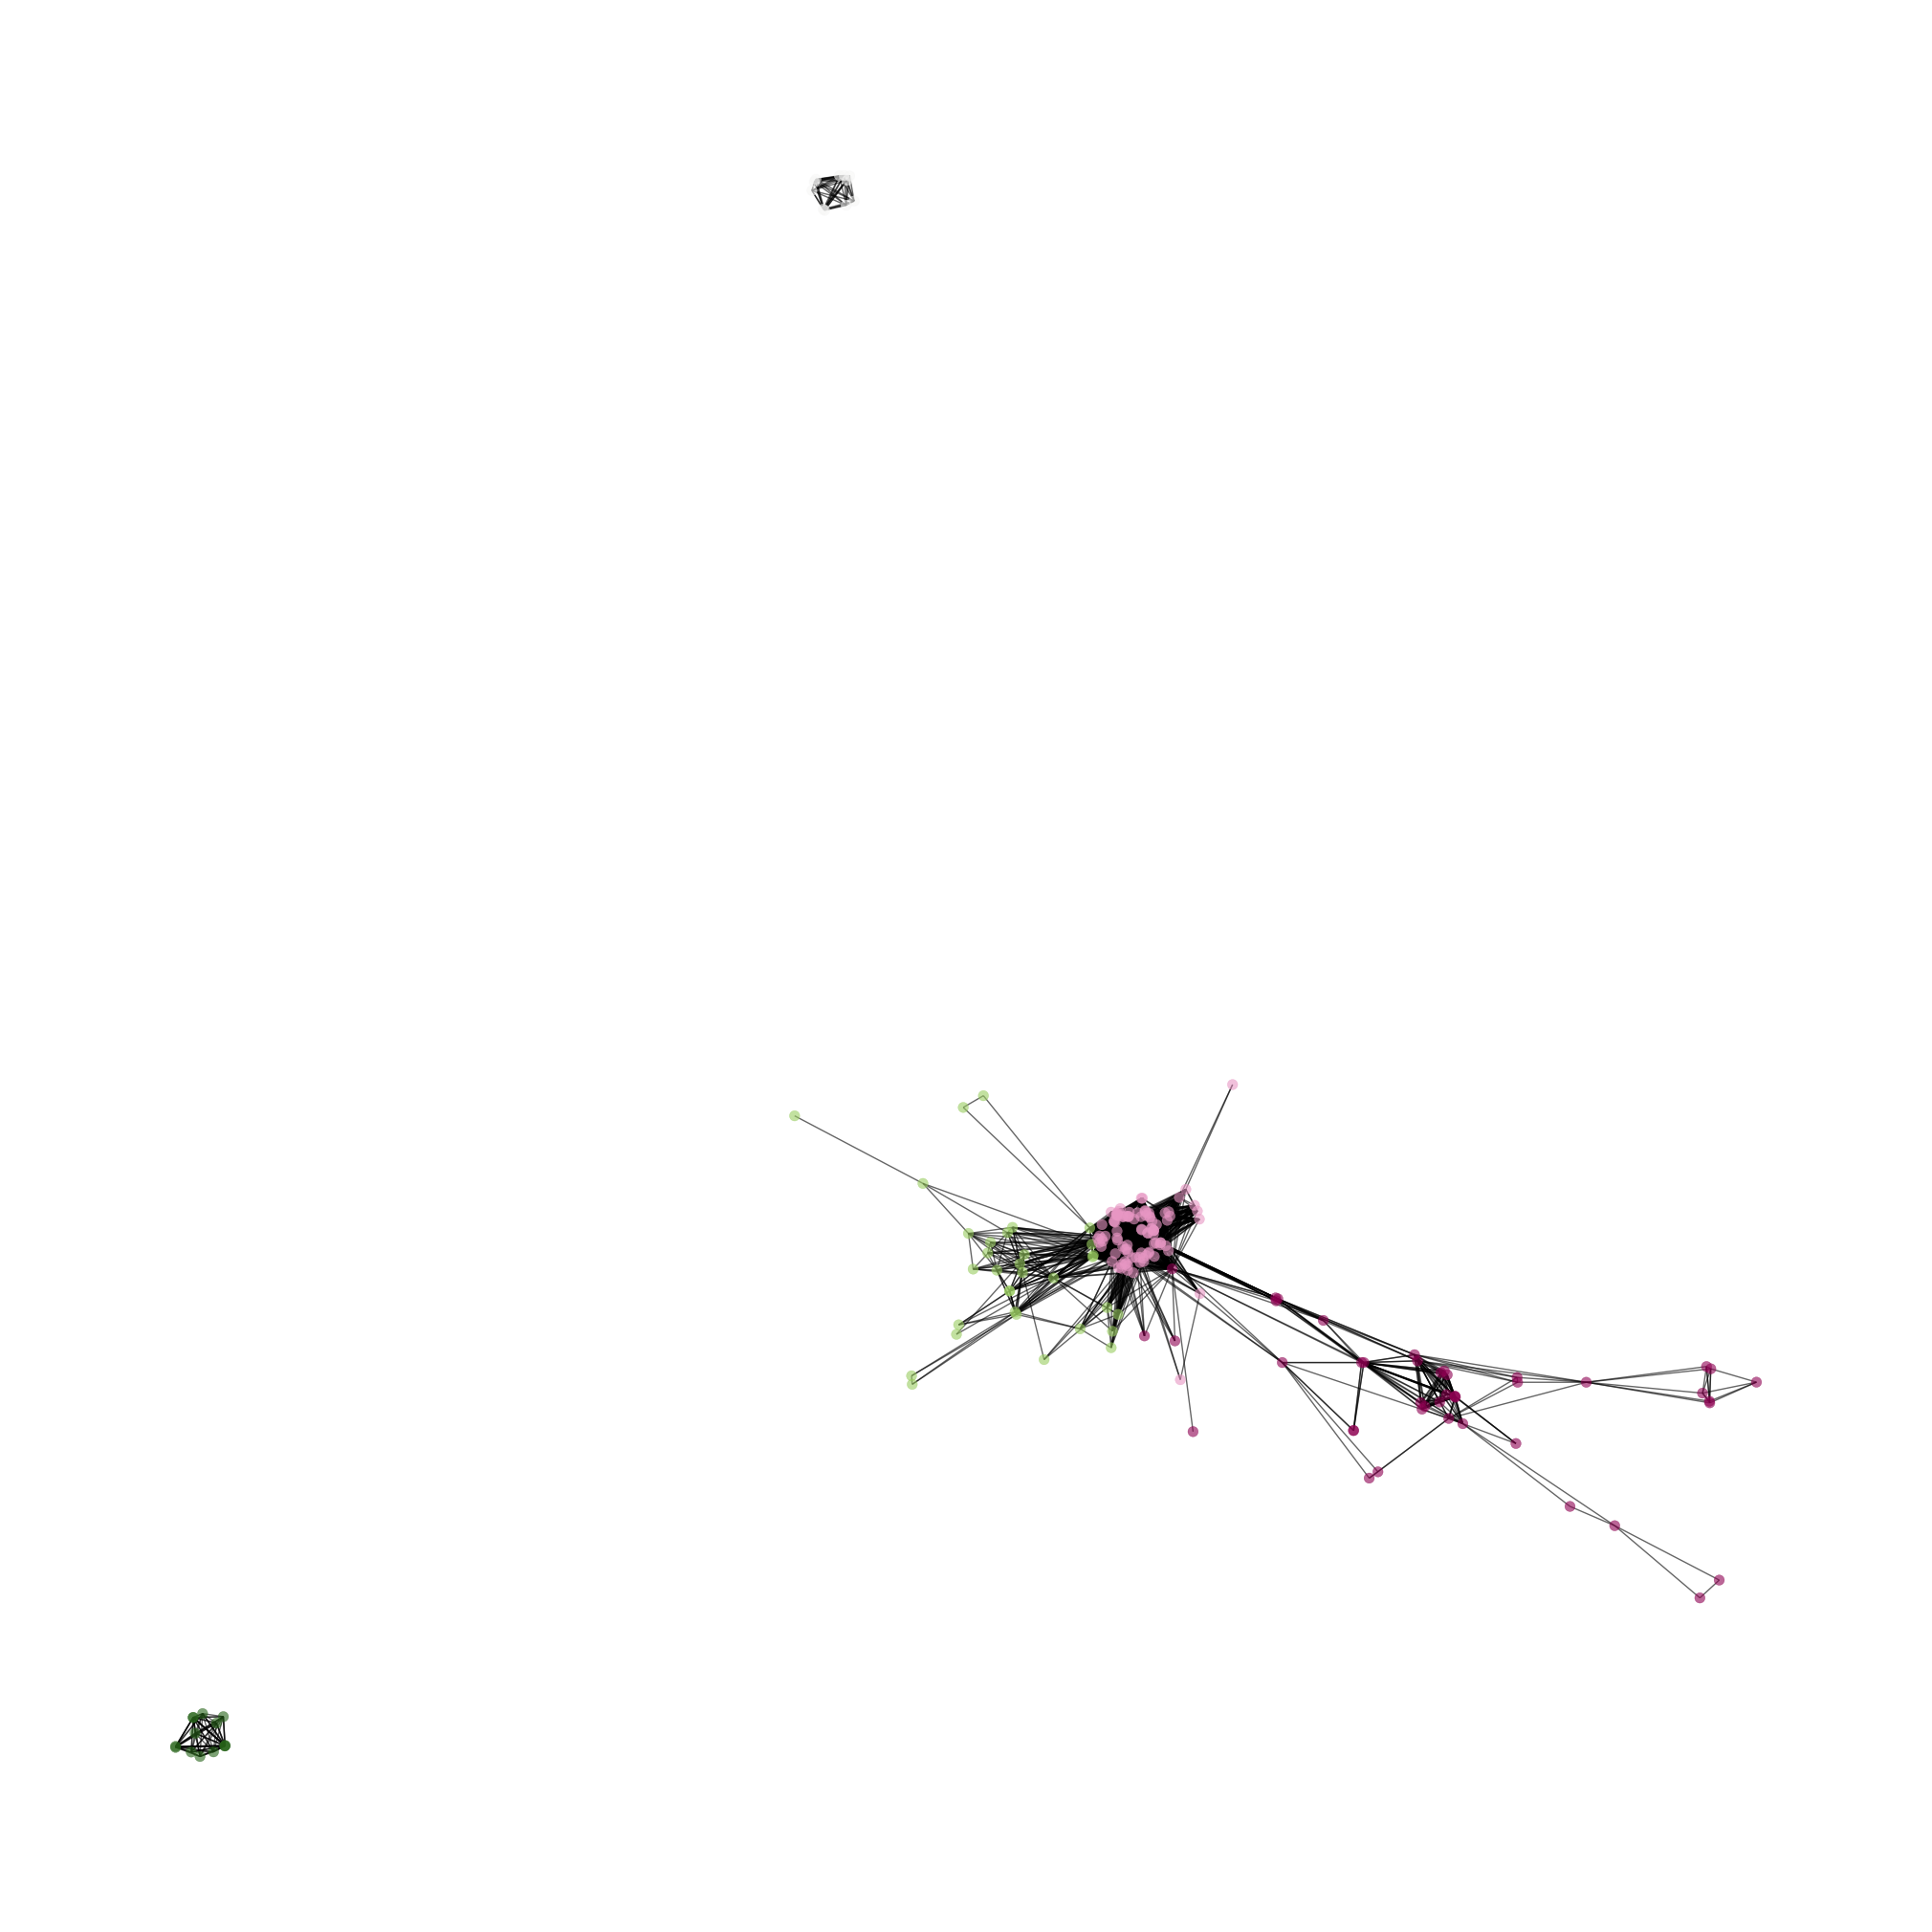

In [37]:
draw_graph(YEAR, G)

In [38]:
central_info(G, 0, 3)

,title,display_id,view_count
50041,Dave Matthews Band - Satellite,GAamgBPebsk,4548555.0
502292,"Saudagar - 1/13 - Bollywood Movie - Nutan, Ami...",JQlhsl8sWIw,1509745.0
502379,Vivah - 14/14 - Bollywood Movie - Shahid Kapoo...,eCHfVf7Kszg,18440090.0


In [39]:
graph.categories.value_counts()

Music                    7349
Entertainment            2270
Comedy                   1140
Howto & Style             627
Film & Animation          535
Gaming                    365
Education                 284
Sports                    251
Science & Technology      241
People & Blogs            239
Autos & Vehicles          218
Pets & Animals            165
News & Politics           112
Travel & Events            73
Nonprofits & Activism      22
Name: categories, dtype: int64

There are 14 nodes and 73 edges present in the Graph


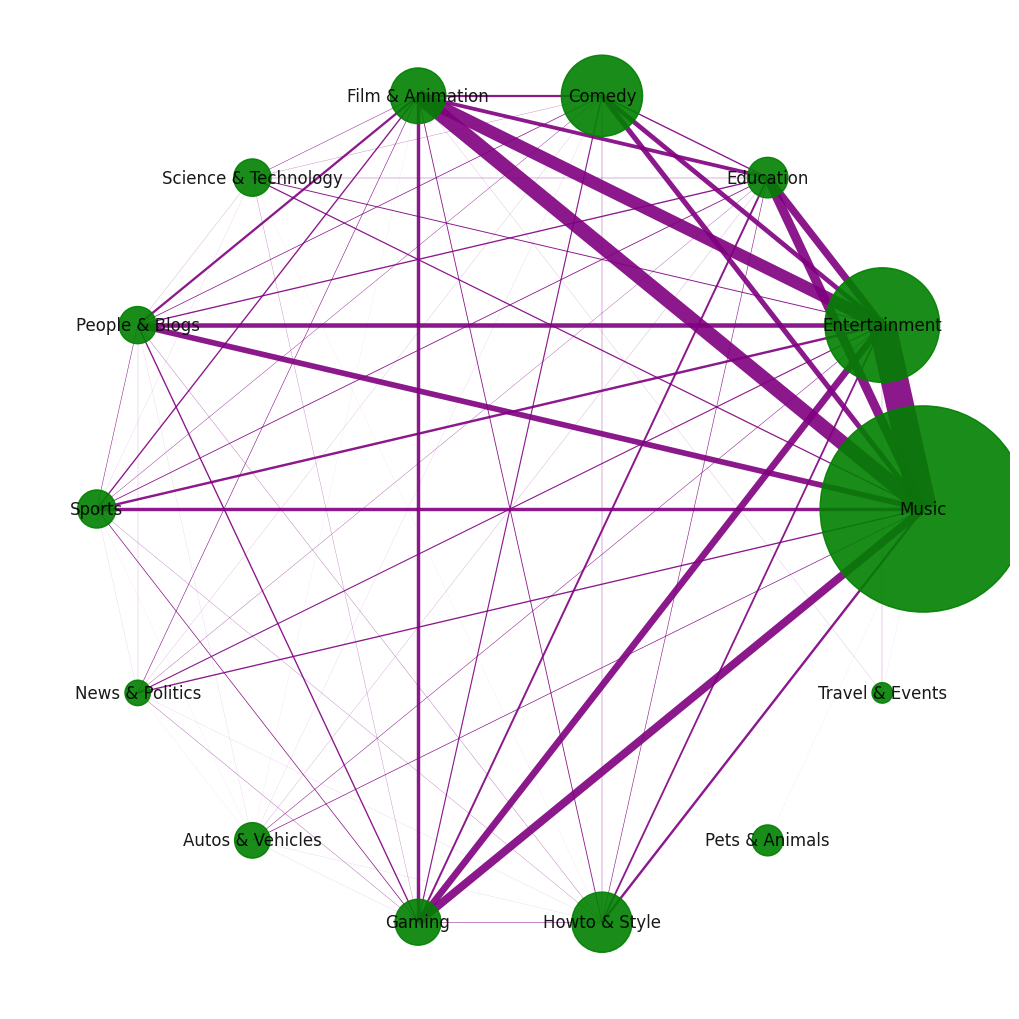

In [40]:
connection_G = categories_connection(G, display_id)
print(f"There are {connection_G.number_of_nodes()} nodes and {connection_G.number_of_edges()} edges present in the Graph")    
category_connection(YEAR, connection_G, graph, 20, 3)

#### 2012

The max number of tags in videos in 2012 is: 96
Number of channels:  6782
Number of videos:  29264
There are 24771 nodes and 36543896 edges present in the Graph
Number of edges that will be removed 36533958
Number of components that will be removed 117
The maximum degree of the Graph is 90
The minimum degree of the Graph is 1
The average degree of the nodes in the Graph is 30.7
The most frequent degree of the nodes found in the Graph is 79
The graph is not connected
There are 16 connected components in the Graph
Component sizes: [ 11  12  12  13  15  15  16  18  25  25  28  28  71  91 101 111]


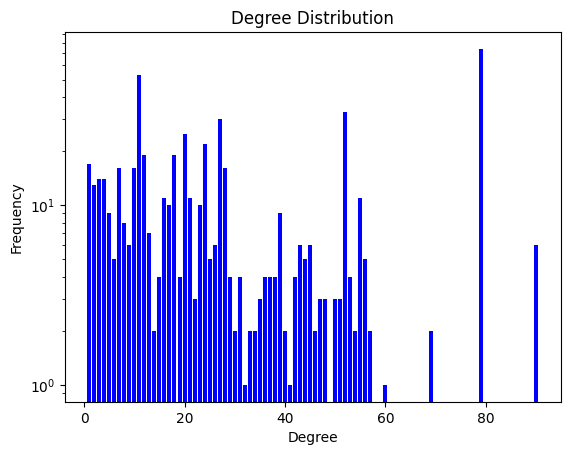

CPU times: user 3min 3s, sys: 18.3 s, total: 3min 21s
Wall time: 3min 21s


In [41]:
%%time

# prepare data
YEAR = 2012
graph = pd.read_feather("yearly_wo_desc/2012_yt_metadata_wo_desc_dislike.feather")
graph = graph.drop(["duration", "like_count"], axis=1)
# choosing the most popular video in YouTube because we want to explore the connection between
graph = graph.sort_values(by=['view_count'], ascending=False)[:int(len(graph)*0.01)] # 0.007
graph.tags = graph.tags.apply(prepare_tags)
graph['count_tags'] = graph.tags.apply(count_tags)
print(f"The max number of tags in videos in {YEAR} is:", graph.count_tags.max())

tags_matrix, tags_list = conv_to_matrix(graph, min_df = 100)
display_id = graph.display_id.values
channel_id = graph.channel_id.values
print("Number of channels: ", len(np.unique(channel_id)))
print("Number of videos: ", tags_matrix.shape[0])
# Graph creation
G = Create_Graph(tags_matrix, tags_list, channel_id, display_id)
print(f"There are {G.number_of_nodes()} nodes and {G.number_of_edges()} edges present in the Graph")

G = filtering(G, 20)
G = removing(G, 10)
save(G, f'networkdata{YEAR}.json')

# Graph analysis
degrees = [v for (n, v) in G.degree()]
print(f"The maximum degree of the Graph is {np.max(degrees)}")   
print(f"The minimum degree of the Graph is {np.min(degrees)}")
print(f"The average degree of the nodes in the Graph is {np.mean(degrees):.1f}")  
print(f"The most frequent degree of the nodes found in the Graph is {stats.mode(degrees)[0][0]}") 
if nx.is_connected(G):
    print("The graph is connected")
else:
    print("The graph is not connected")
    
print(f"There are {nx.number_connected_components(G)} connected components in the Graph") 
size = np.sort([len(c) for c in nx.connected_components(G)])
print('Component sizes:', size)

degree = plot_degree_distribution(G)

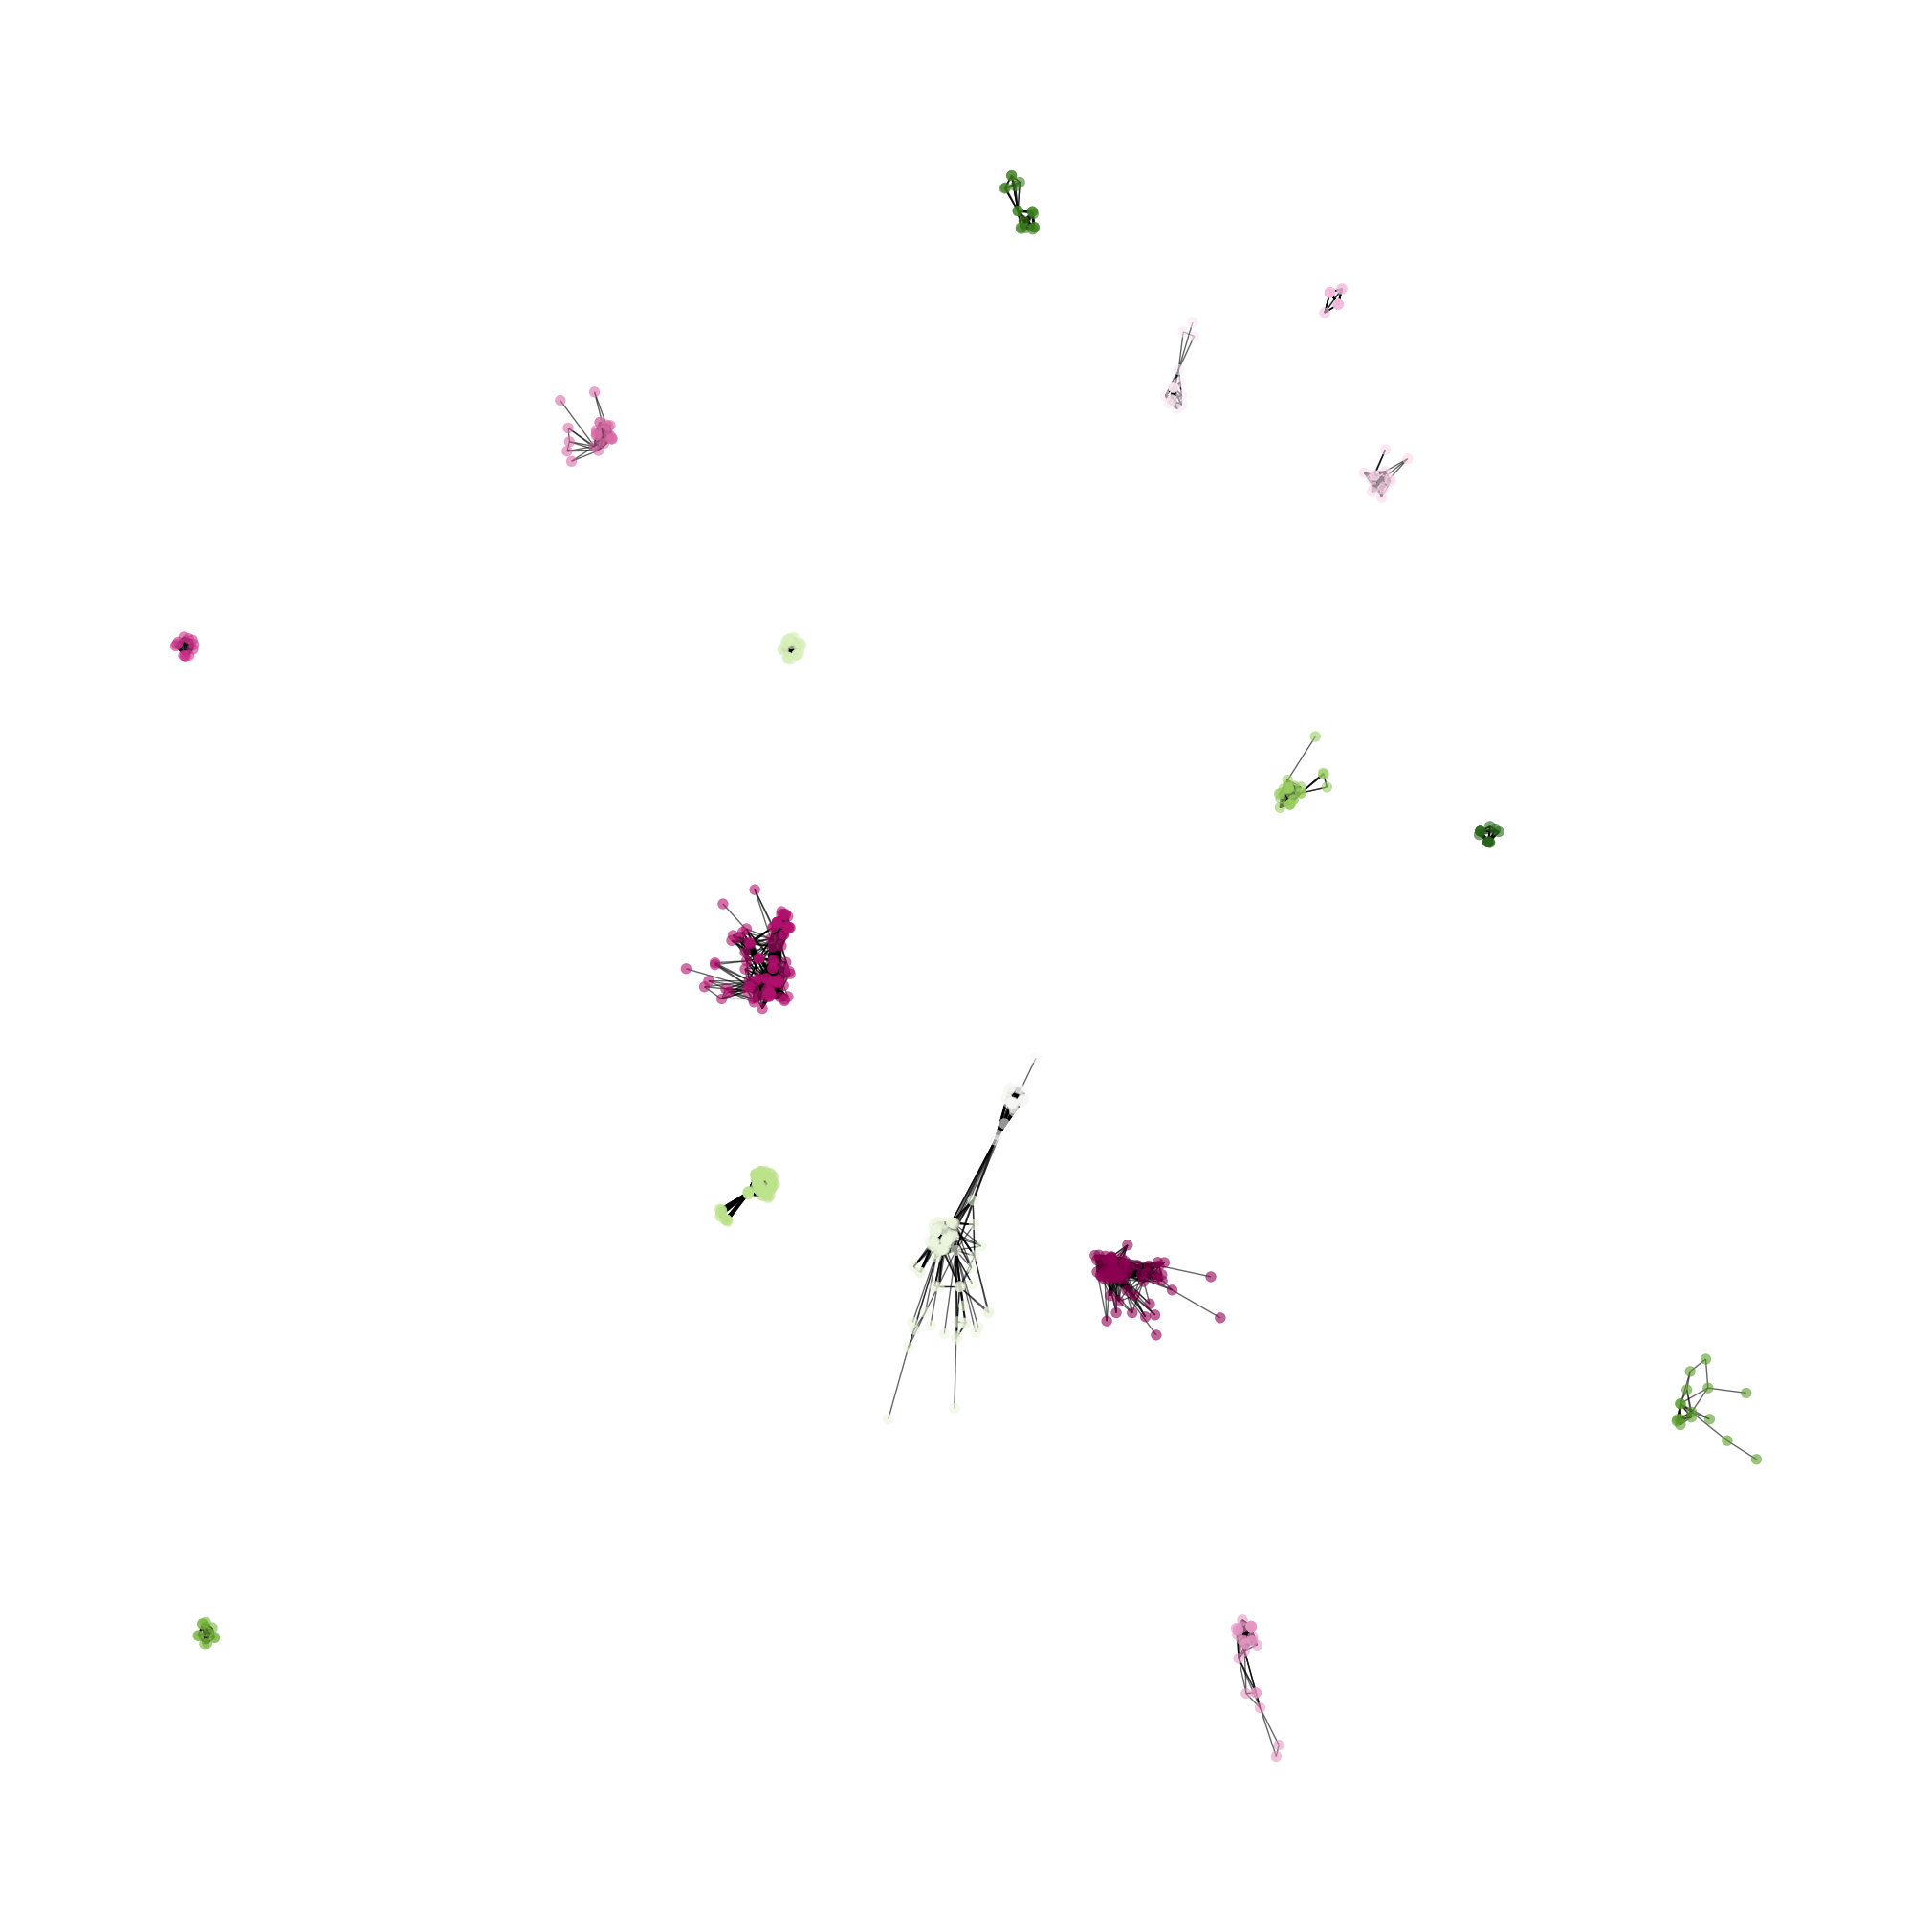

In [42]:
draw_graph(YEAR, G)

In [43]:
central_info(G, 0, 2)

,title,display_id,view_count
1307657,Men's Vault Final - London 2012 Olympics,Nkd39-BwXto,2368713.0
17464,"Let's Play Minecraft with Geoff, Jack, Michael...",FrLgREKD4kk,15607513.0
2346131,How to Make Pet Stuff for Your Doll 2,li7E4OBBtvE,1684654.0
827196,COLE's TREAD ASSAULT 9444 Lego Ninjago Stop Mo...,mRlJKIjzIEk,2622067.0
155644,Sophia Grace & Rosie Do Tea with Justin Bieber!,CIb49SXqNtE,16570539.0
2887521,Minecraft: Enderman's Game,rTecPsfEA_M,2453590.0
2839037,ABC Song in the Clouds,y9ifzj87WCw,2803277.0
1094120,P!nk - True Love (Official Lyric Video),c6vsHF3E9NU,14351612.0
297930,Justin Bieber - As Long As You Love Me ft. Big...,A2do57ag59k,30231371.0
1119987,Paatu Esa Paatu - Senthamizh Selvan - Tamil Ro...,FXqAz3LYq6s,1975446.0


In [44]:
graph.categories.value_counts()

Music                    7829
Entertainment            7616
Gaming                   3108
Film & Animation         2396
Comedy                   1927
Howto & Style            1523
Education                1009
Sports                    894
People & Blogs            717
Autos & Vehicles          614
Science & Technology      590
News & Politics           414
Pets & Animals            283
Travel & Events           254
Nonprofits & Activism      85
                            5
Name: categories, dtype: int64

There are 15 nodes and 104 edges present in the Graph


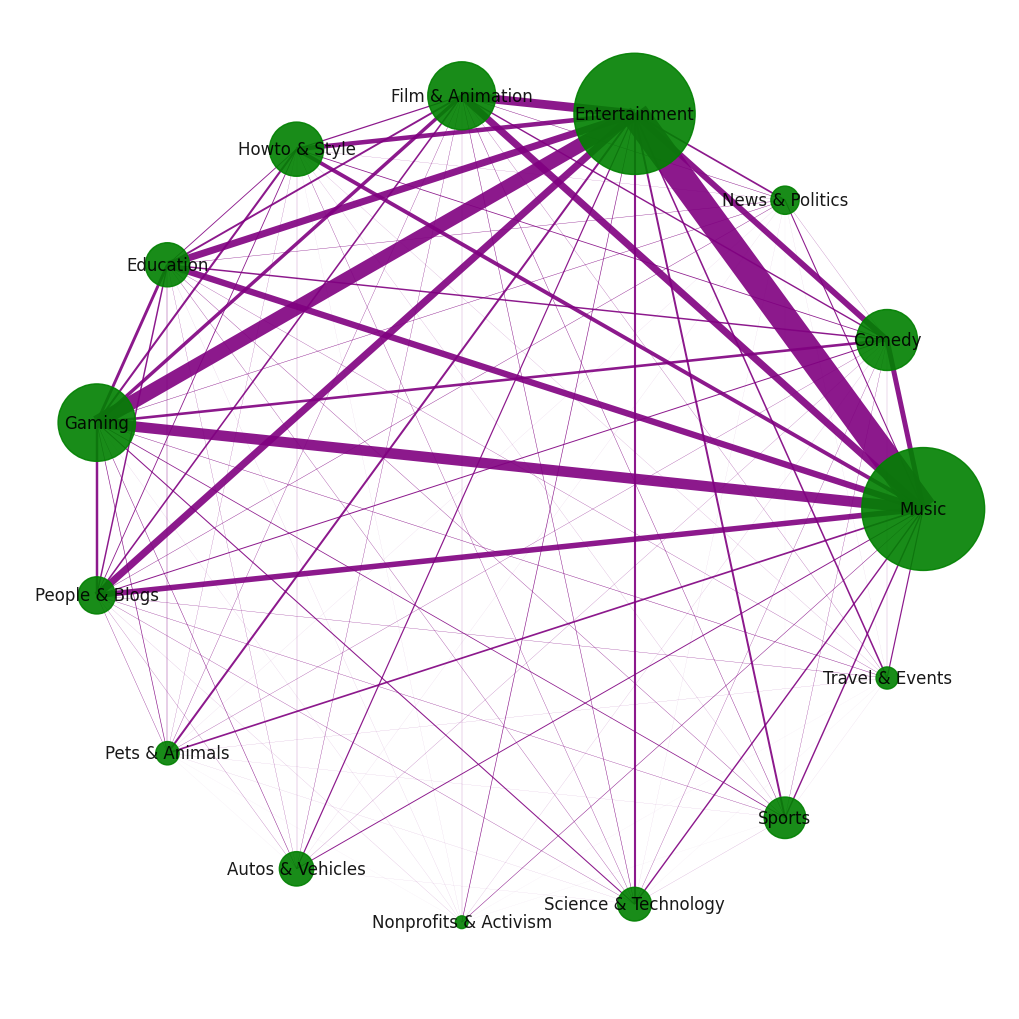

In [45]:
connection_G = categories_connection(G, display_id)
print(f"There are {connection_G.number_of_nodes()} nodes and {connection_G.number_of_edges()} edges present in the Graph")    
category_connection(YEAR, connection_G, graph, 20, 1)

The drawback here is that the final graph is much smaller especially after filtering. But there is no uncertainty in "clustering" because we don't let the single channel be a single component in a graph(filtering out those tags which appeared in only one channel). 